In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules')
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LogNorm
import numpy as np
import math as ma

from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import LambdaCDM
from astropy import units as u
import astropy 

import loadSP as lsp
import cosmo
import halos

plt.rcParams['figure.figsize'] = (13,11)
plt.rcParams['font.size'] = 32
import gc

In [2]:
# ##########################################################
# Format tick labels using their exponent only... 
# ##########################################################
def log_formatter(x,pos):
    return format(np.log10(x), '.0f')
logfmt  = FuncFormatter(log_formatter)

def log_GHzFormatter(x,pos):
    return format(np.log10(x)-9.0, '.0f')
logGHzfmt  = FuncFormatter(log_GHzFormatter)

def GHzFormatter(x,pos):
    return format(x/1e9, '.2e')
GHzfmt  = FuncFormatter(GHzFormatter)

def div_formatter(x,pos):
    return format(x/1000, '.1f')
divfmt  = FuncFormatter(div_formatter)

nullfmt = NullFormatter()
labelsize = 24

In [24]:
# Cosmology from my paper
myCosmo = FlatLambdaCDM(H0=71.0, Om0=0.2669999897, Ob0=0.0445, name='myCosmo')
# Make sure we have halo information for this z... hop/...
z = 12.0
num = 43 # This is the output_00num file that has the "info_" for finding the boxsize... see map above.
boxsizecm = lsp.getBoxSize(num,"/Users/earnric/Research/RAMSES-Data/27Aug15-3Mpc/")
print("boxsize from info {:.2f} at z={}".format((boxsizecm * u.cm).to(u.kpc),z))

print("Using astropy cosmology: size {:.2f}".format((3 * u.Mpc/(1.0+z) * 1/0.71).to(u.kpc)))


boxsize from info 324.44 kpc at z=12.0
Using astropy cosmology: size 325.03 kpc


In [25]:
sizeKeys = np.loadtxt('zKeysForSPfiles.txt',skiprows=1)
print("Boxsize from kKey file = {}".format(sizeKeys[sizeKeys[::,0] == z][0,1] * u.kpc))

Boxsize from kKey file = 324.44 kpc


In [26]:
locs, mass, bt, Z, PZ, PPF = lsp.loadSP(z)

In [27]:
baseAge = cosmo.ageAtz(71,z) # ageAtZ return Myr, parameters are H and z
spAges = baseAge - bt/1e6
print("min sp age {:.2f} Myr".format(min(spAges)))
print("max sp age {:.2f} Myr".format(max(spAges)))
print("min sp Z {:.2e} Solar".format(min(Z)))
print("max sp Z {:.2e} Solar".format(max(Z)))

min sp age 1.24 Myr
max sp age 180.15 Myr
min sp Z 5.00e-09 Solar
max sp Z 1.13e-01 Solar


In [42]:
# import importlib
# importlib.reload(lsp)
##
## Load the halo locations
## hop halo pos file key:    #   npart,mass,cont.frac,xc,yc,zc,uc,vc,wc
##
halosRawPos = lsp.loadHaloGrps(num) # Returns positions normalized to (-0.5, 0.5)
halosRawPos = halosRawPos[0:300]
tbox = boxsizecm/lsp.cmInPc/1000.0 # Convert cm to kpc
# tbox = sizeKeys[sizeKeys[::,0] == z][0,1]     # This works too.. 
# tbox = (3 * u.Mpc/(1.0+z) * 1/0.71).to(u.kpc) # Last resort!
print("boxsize at z={:.2f} is {:.2f}".format(z,tbox))
halosPos = halosRawPos * tbox
len(halosRawPos)

boxsize at z=12.00 is 324.40


300

# Generate the magnitudes... 

In [44]:
# Setup the cosmology used in the runs
# This provides comoving distance, lumin distance, etc... 
# THis is Seth's cosmology
astroPyCosmo = FlatLambdaCDM(H0=71.0, Om0=0.24, Ob0=0.0449,name='myCosmo')

In [45]:
arcPerKpc = astroPyCosmo.arcsec_per_kpc_comoving(z=9.5)
print('Comoving:',arcPerKpc)
arcPerKpc = astroPyCosmo.arcsec_per_kpc_proper(z=9.5)
print('Proper:',arcPerKpc)


Comoving: 0.020734679928940715 arcsec / kpc
Proper: 0.21771413925387748 arcsec / kpc


In [46]:
kpcPerArcSec = cosmo.arcAtz(71,z=9.5,om=0.24, ol=1.0-0.24) # size of an arcsec at the specified reshift in kpc
print('Proper:',1.0 / kpcPerArcSec)


Proper: 0.21744697332907817


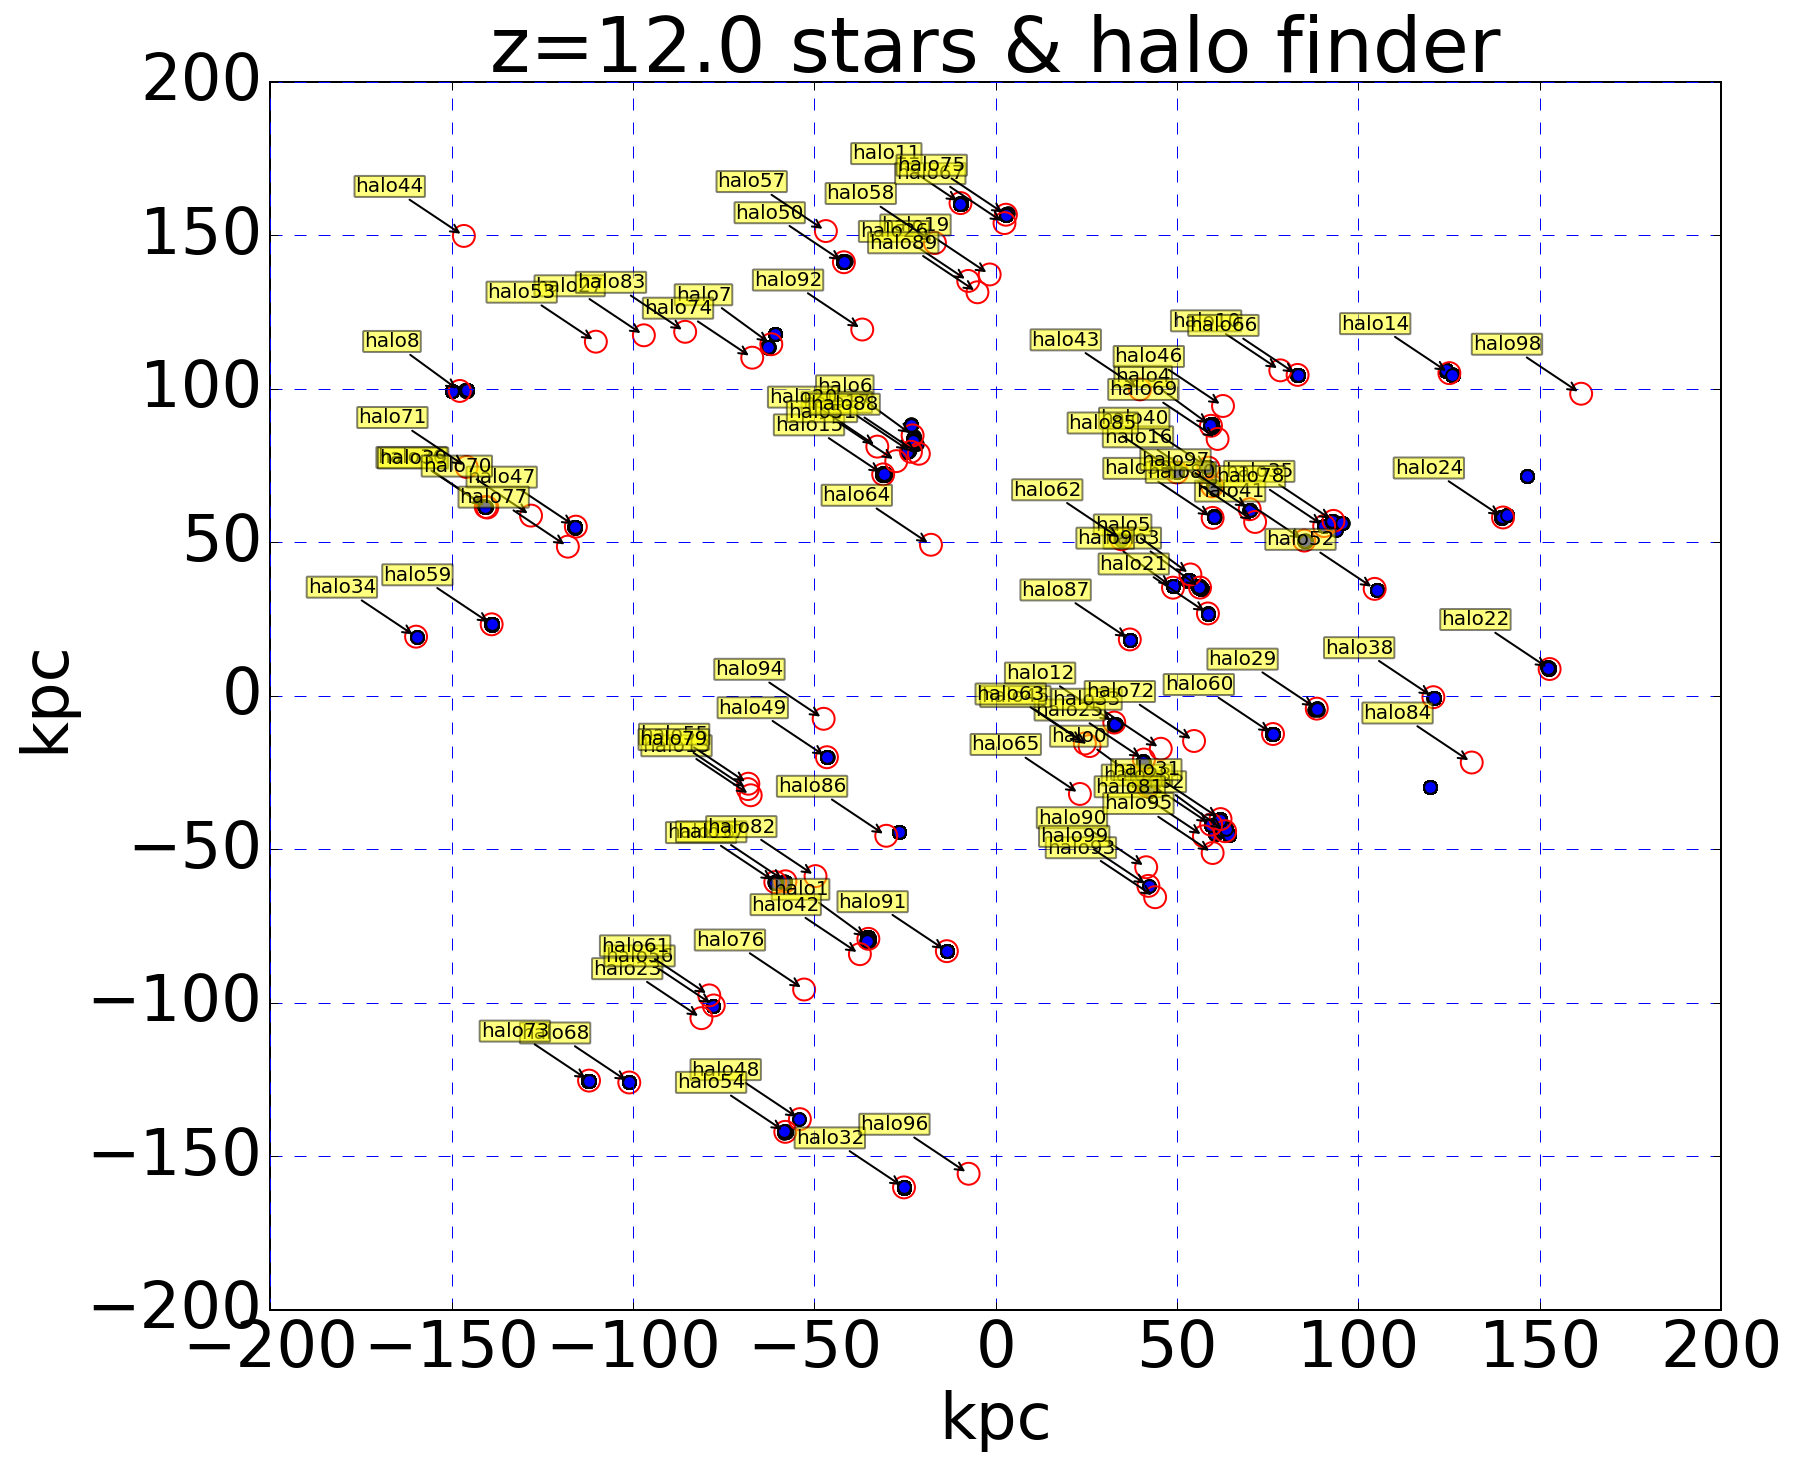

In [47]:
htp = 100
labels = ['halo{0}'.format(i) for i in range(len(halosPos))]
plt.scatter(locs[:,0],locs[:,1],s=40,c='b') # Plot star particles
plt.scatter(halosPos[:htp,0],halosPos[:htp,1],s=120,facecolors='none', edgecolors='r') # Plot halo locs
plt.grid(b=True, which='major', color='b', linestyle='--')
plt.xlabel('kpc')
plt.ylabel('kpc')
plt.title('z=%.1lf stars & halo finder'%z)
for label, x, y in zip(labels, halosPos[:htp,0],halosPos[:htp,1]):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',fontsize=10,
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.show()

11250

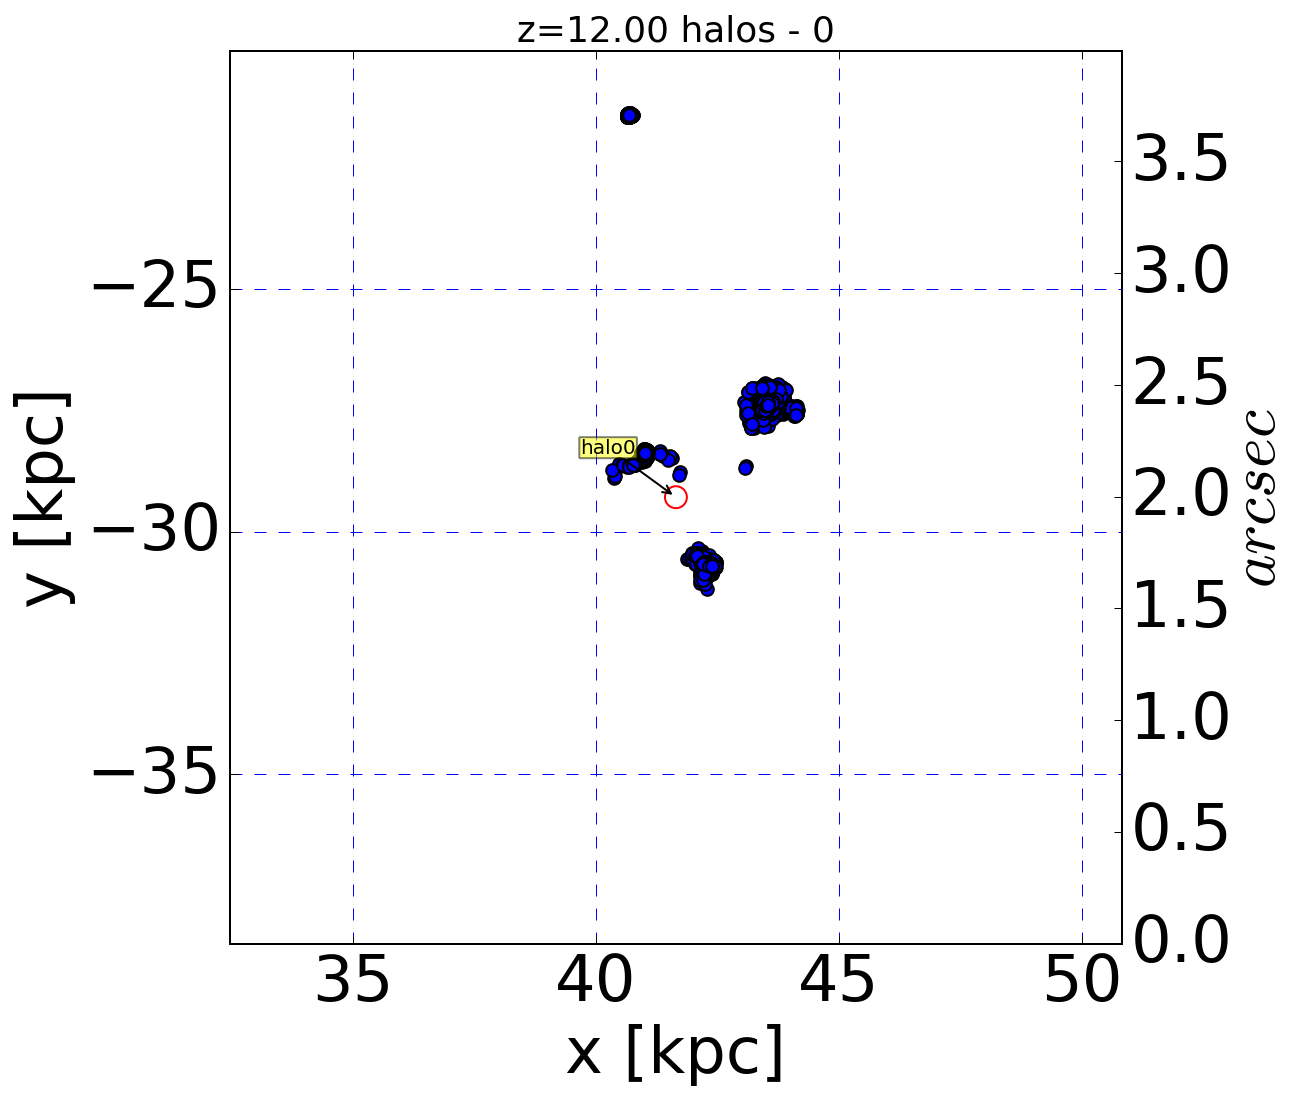

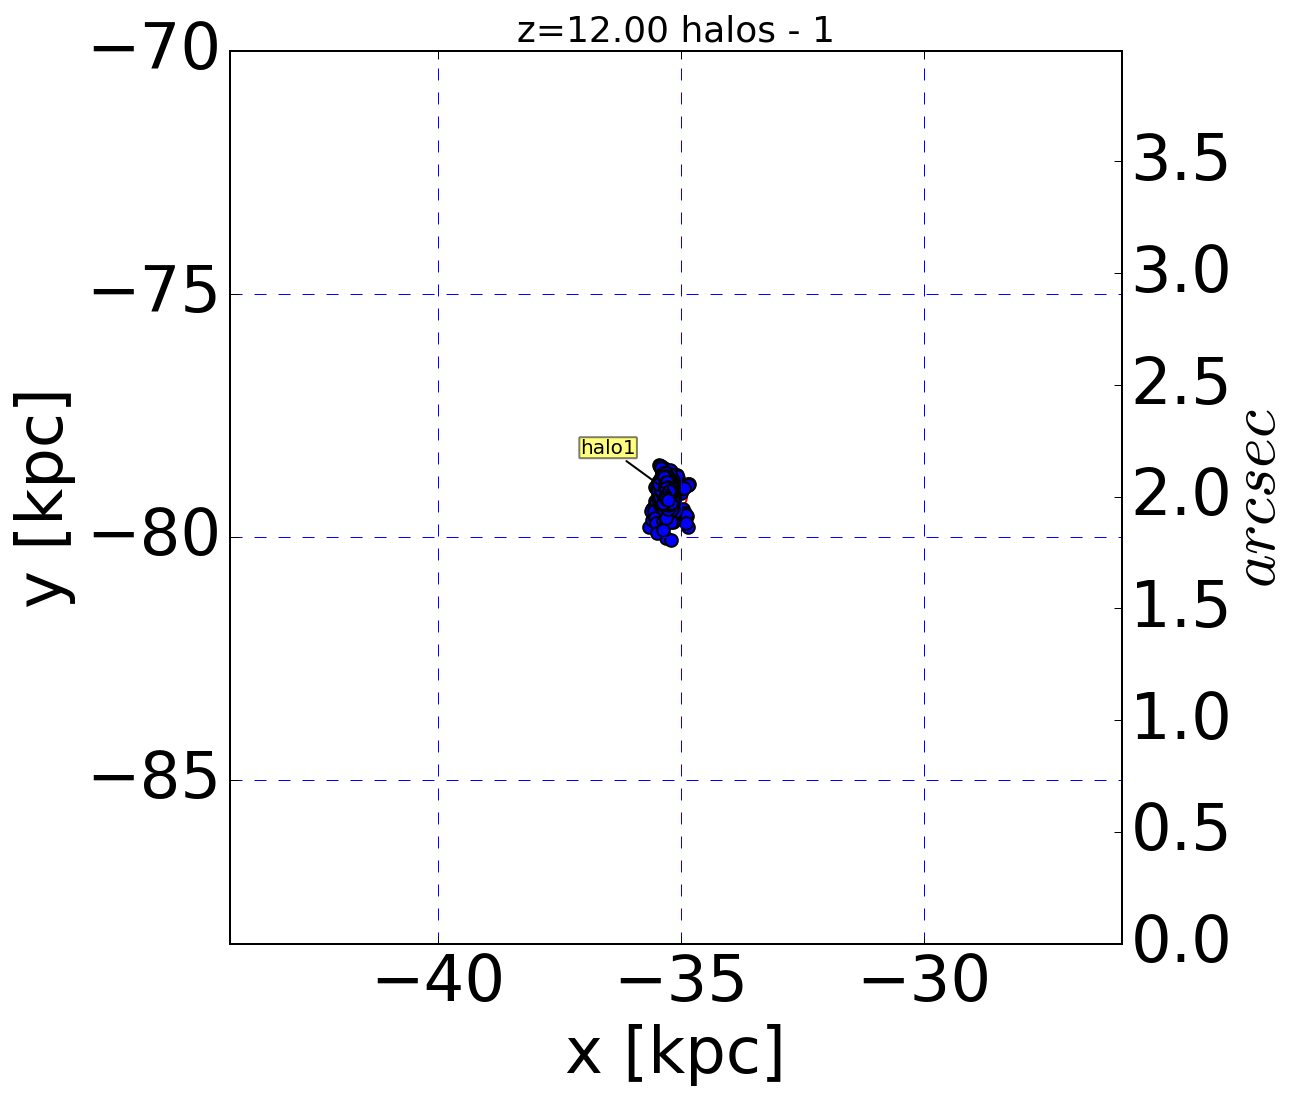

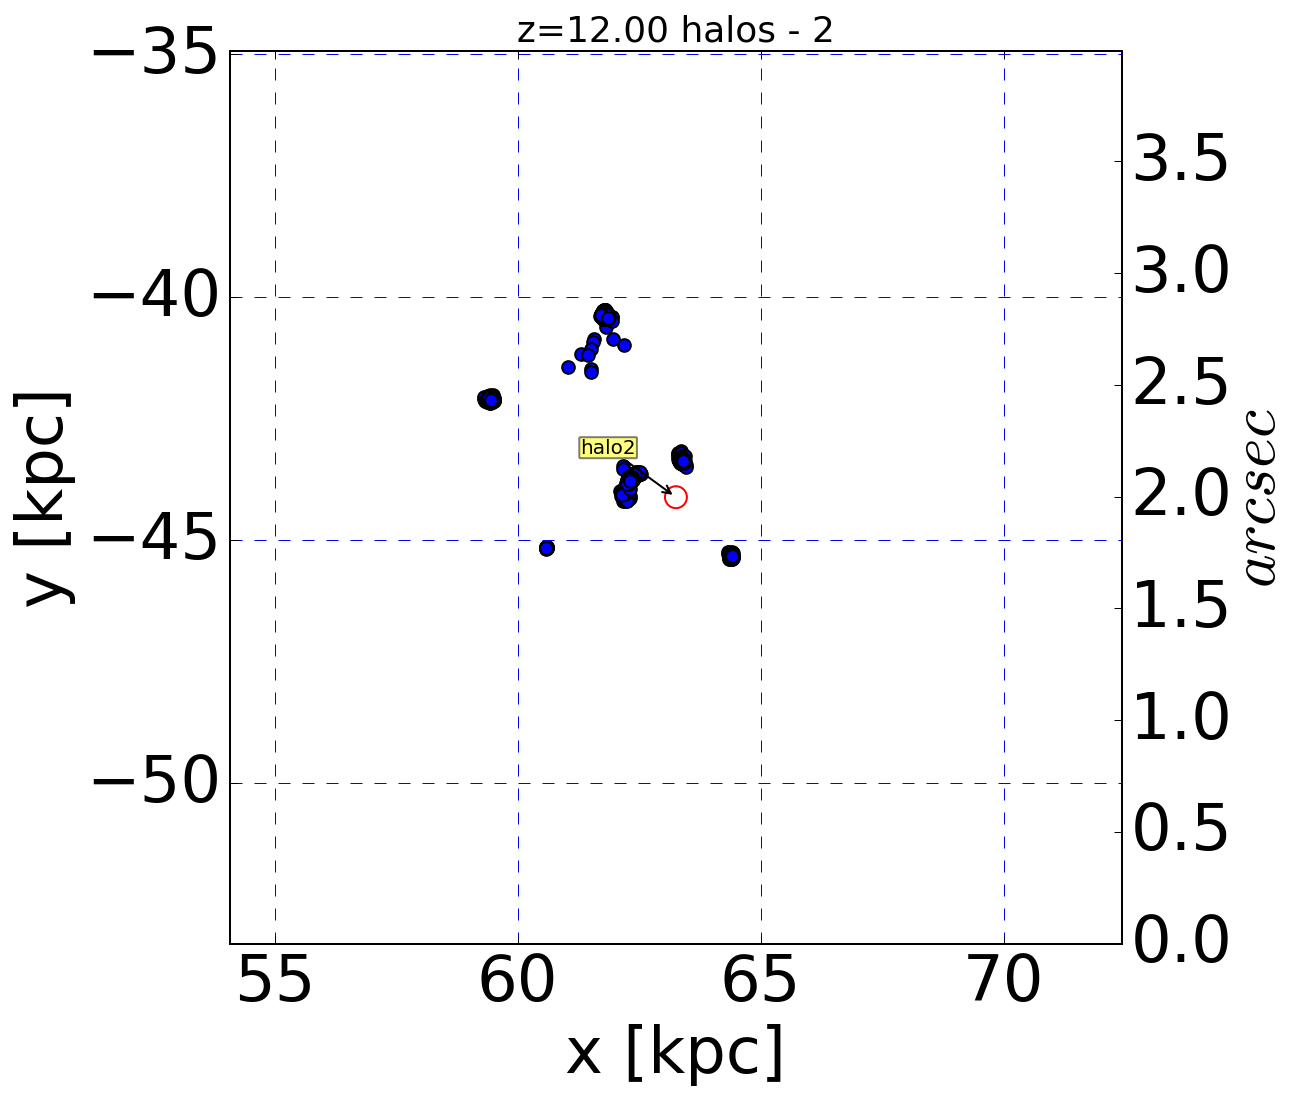

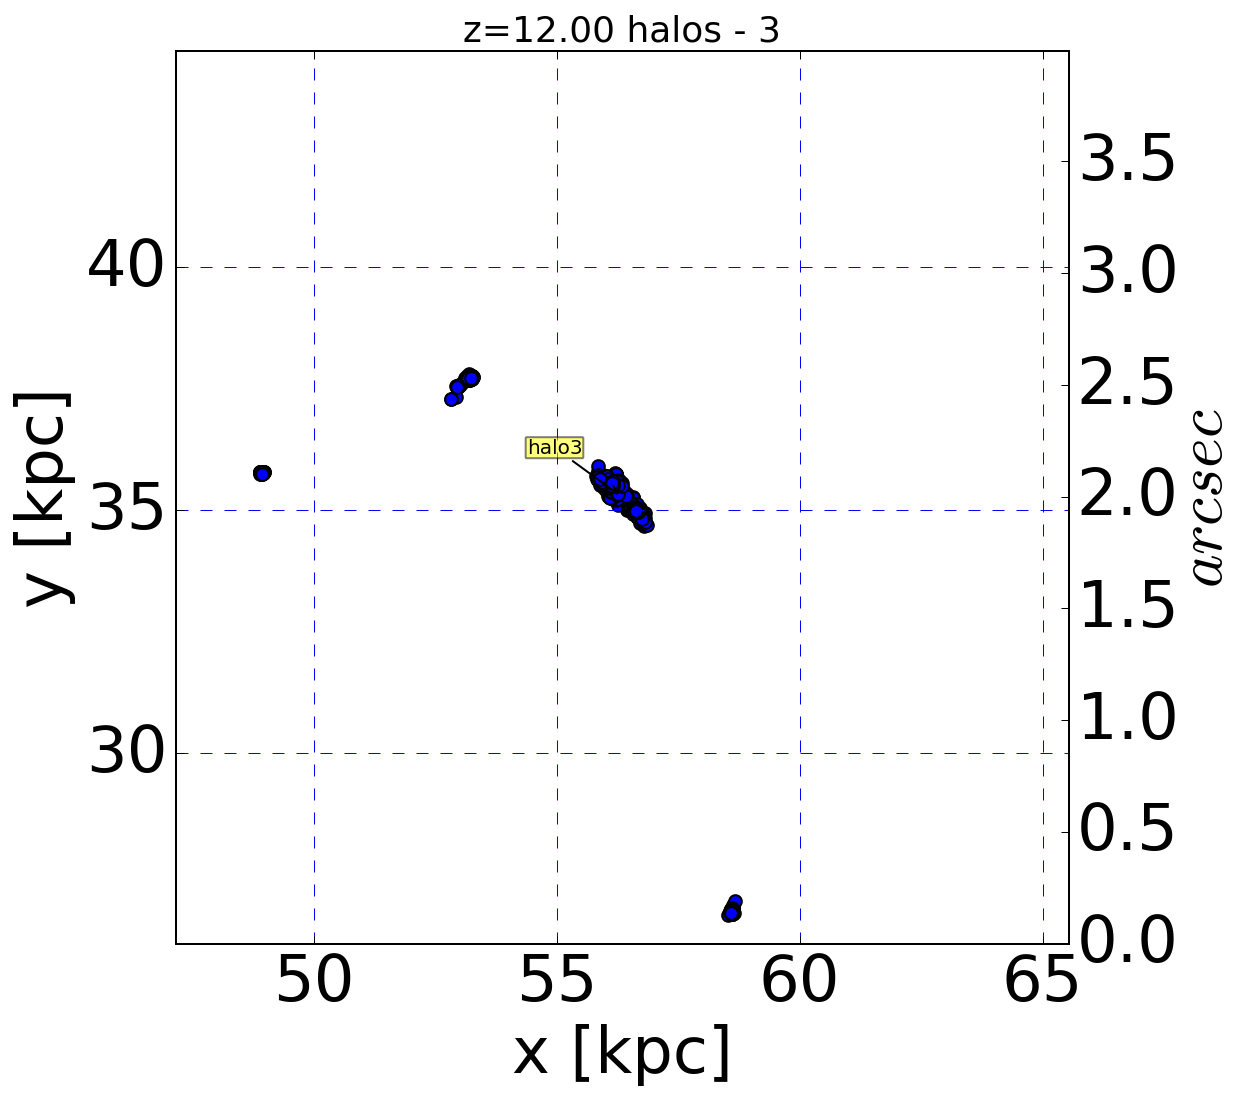

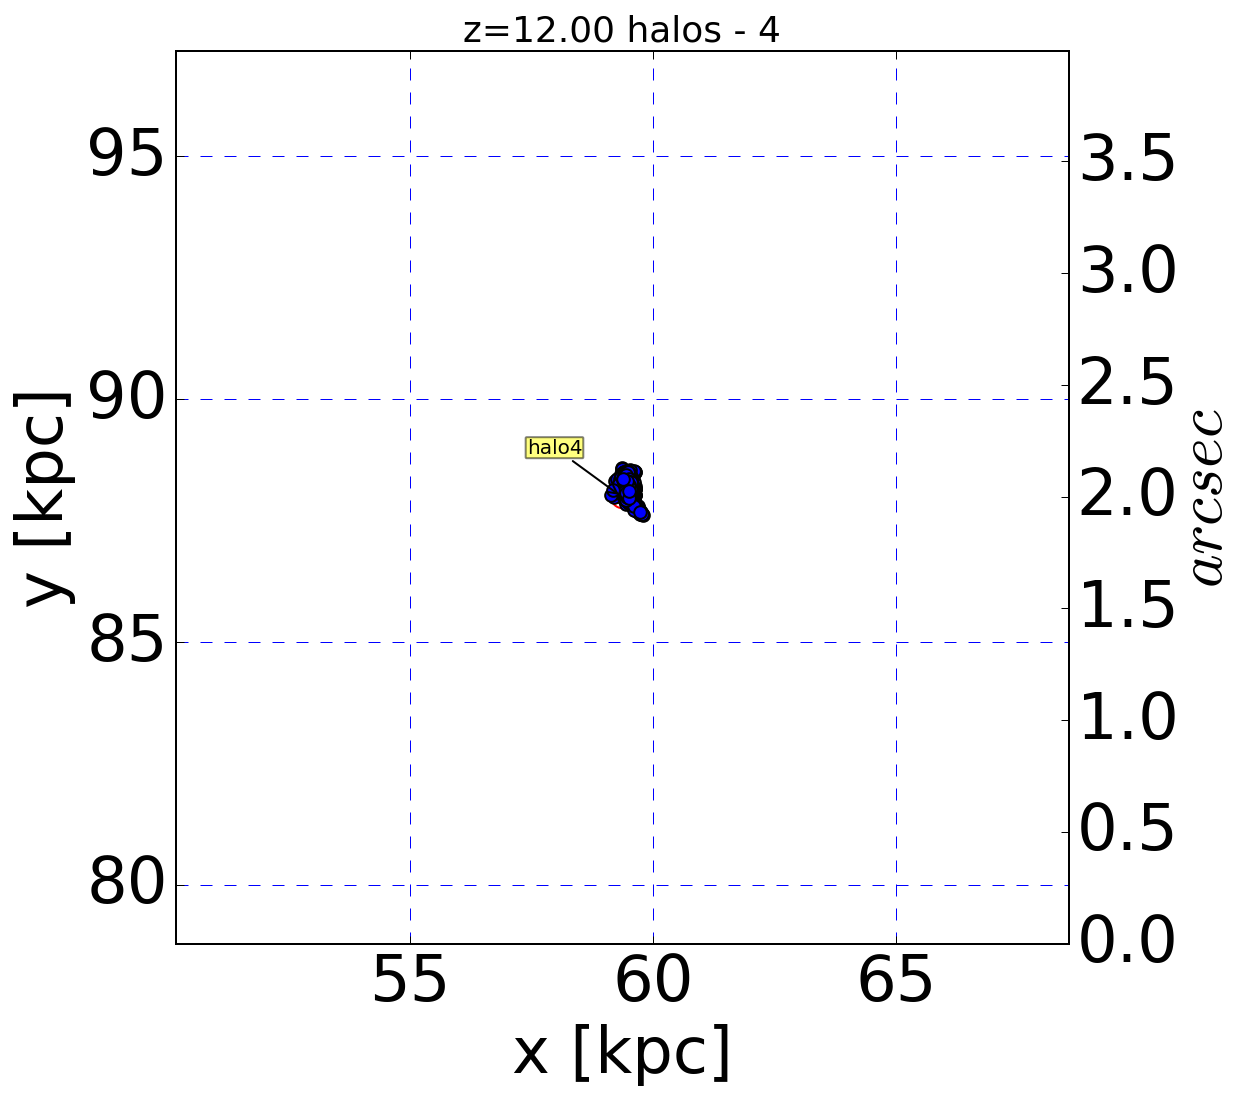

In [49]:
size = 4.0 * u.arcsec / arcPerKpc # Should use cosmology to find kpc for x arcsec... What should I use for x?
size = size.value
for halo in range(0,5):
    ax=halos.pltView(locs,halosPos,halo,z,size)
    hax2 = ax.twinx()
    hax2.set_ylim([0,size/kpcPerArcSec])
    hax2.set_ylabel(r'$arcsec$')
    hax2.yaxis.labelpad = -3
gc.collect()

In [17]:
size,arcPerKpc

(18.372715771737642, <Quantity 0.21771413925387748 arcsec / kpc>)

18.372715771737642 kpc = 4.0 arcsec
Num 5489, Tot Mass 4066617.0773890093 solMass
Num 9389, Tot Mass 7116680.662008287 solMass
Num 3184, Tot Mass 2346481.8309987336 solMass
Num 4501, Tot Mass 3319096.735969313 solMass
Num 4268, Tot Mass 3253390.4074256276 solMass


37279

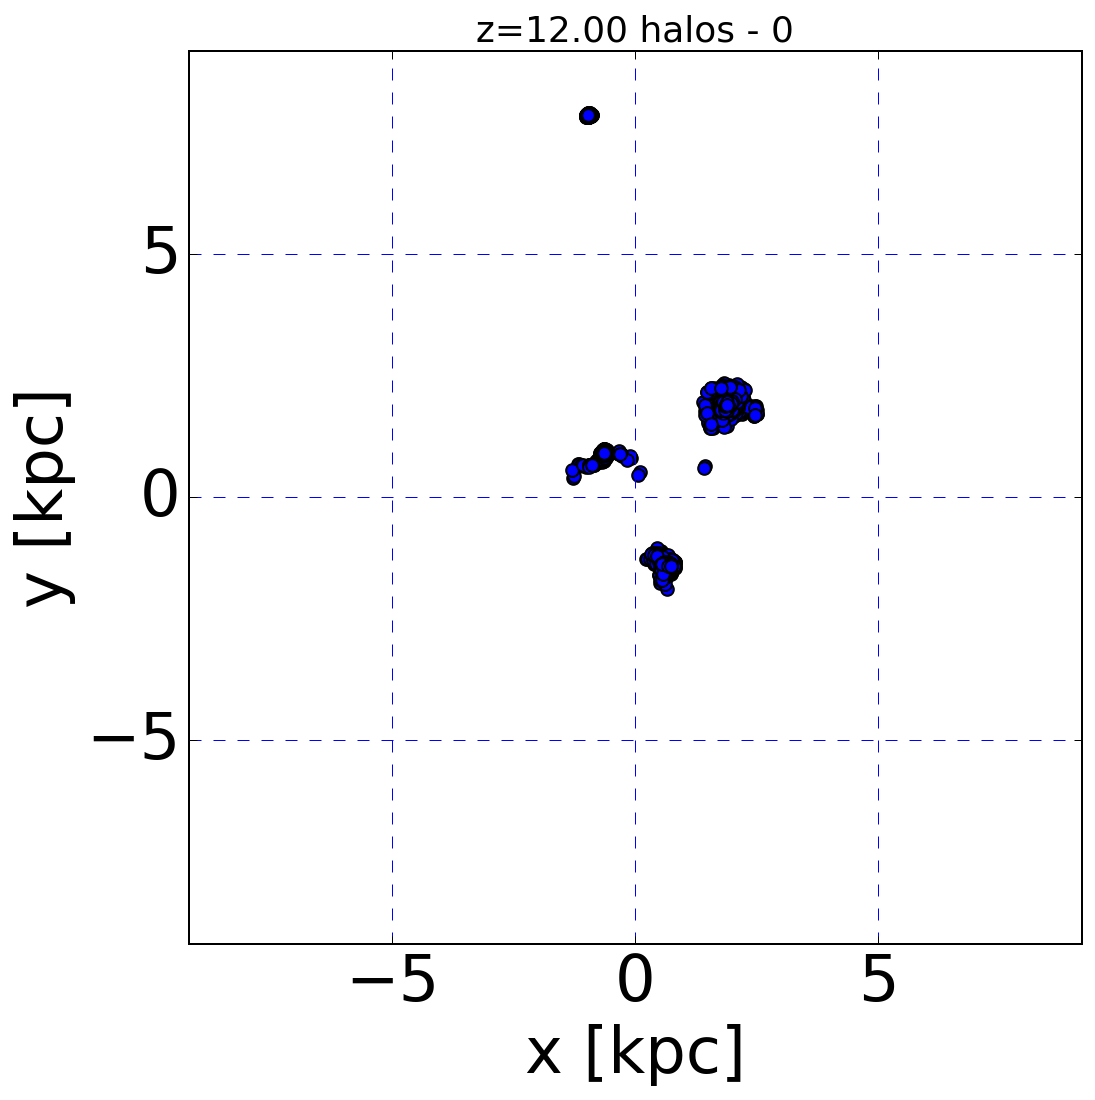

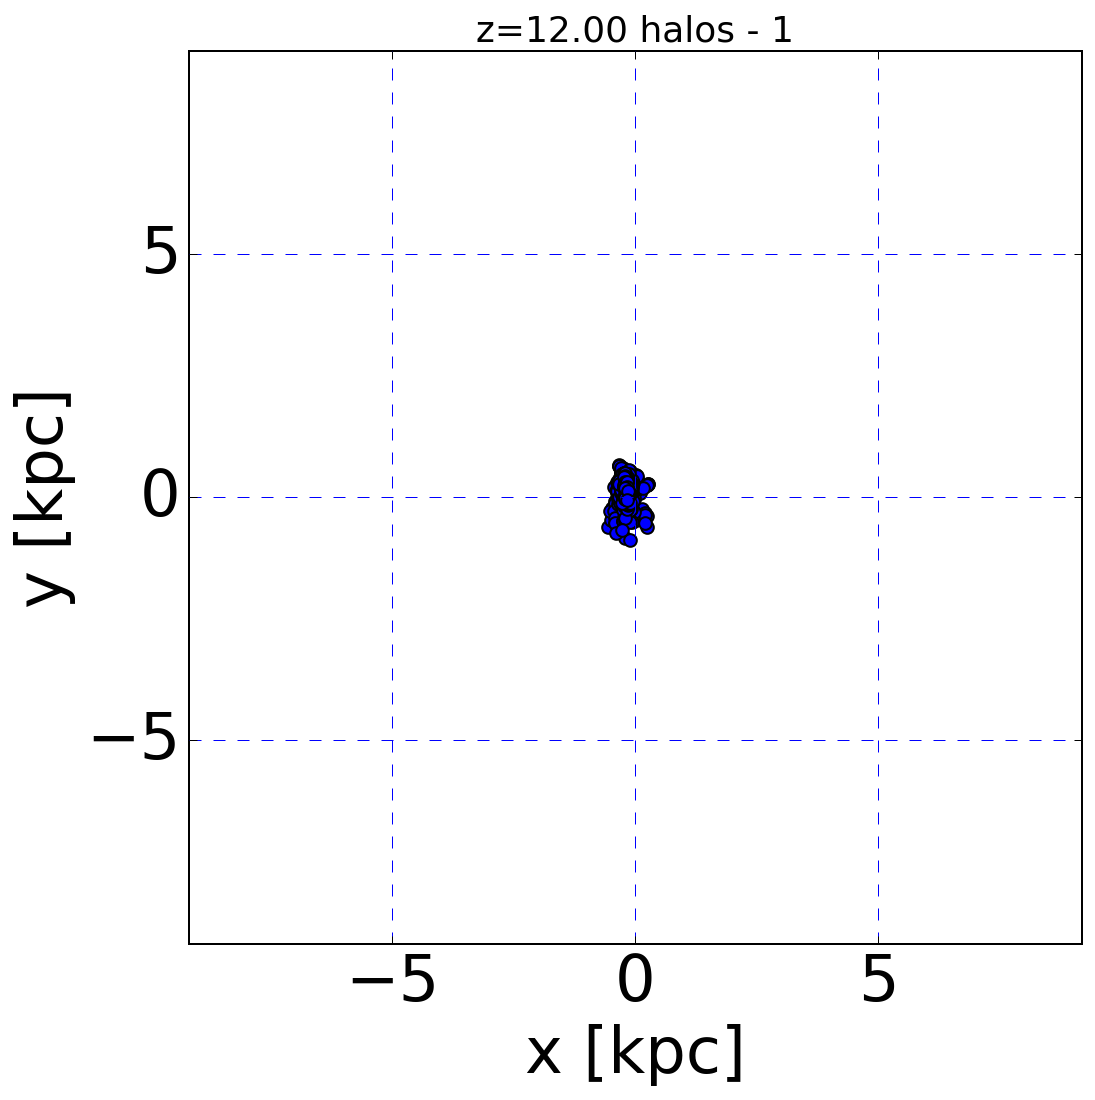

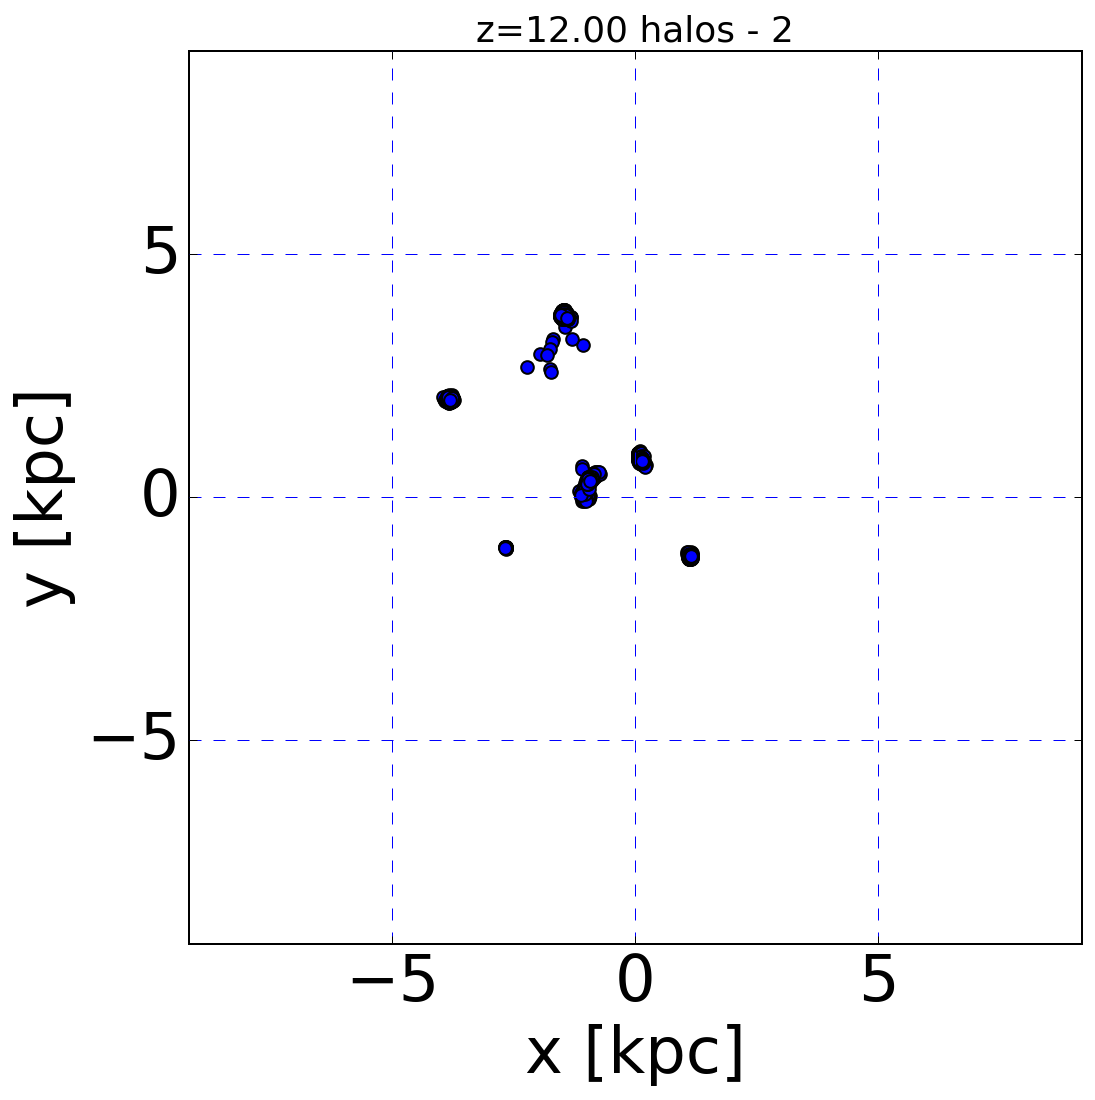

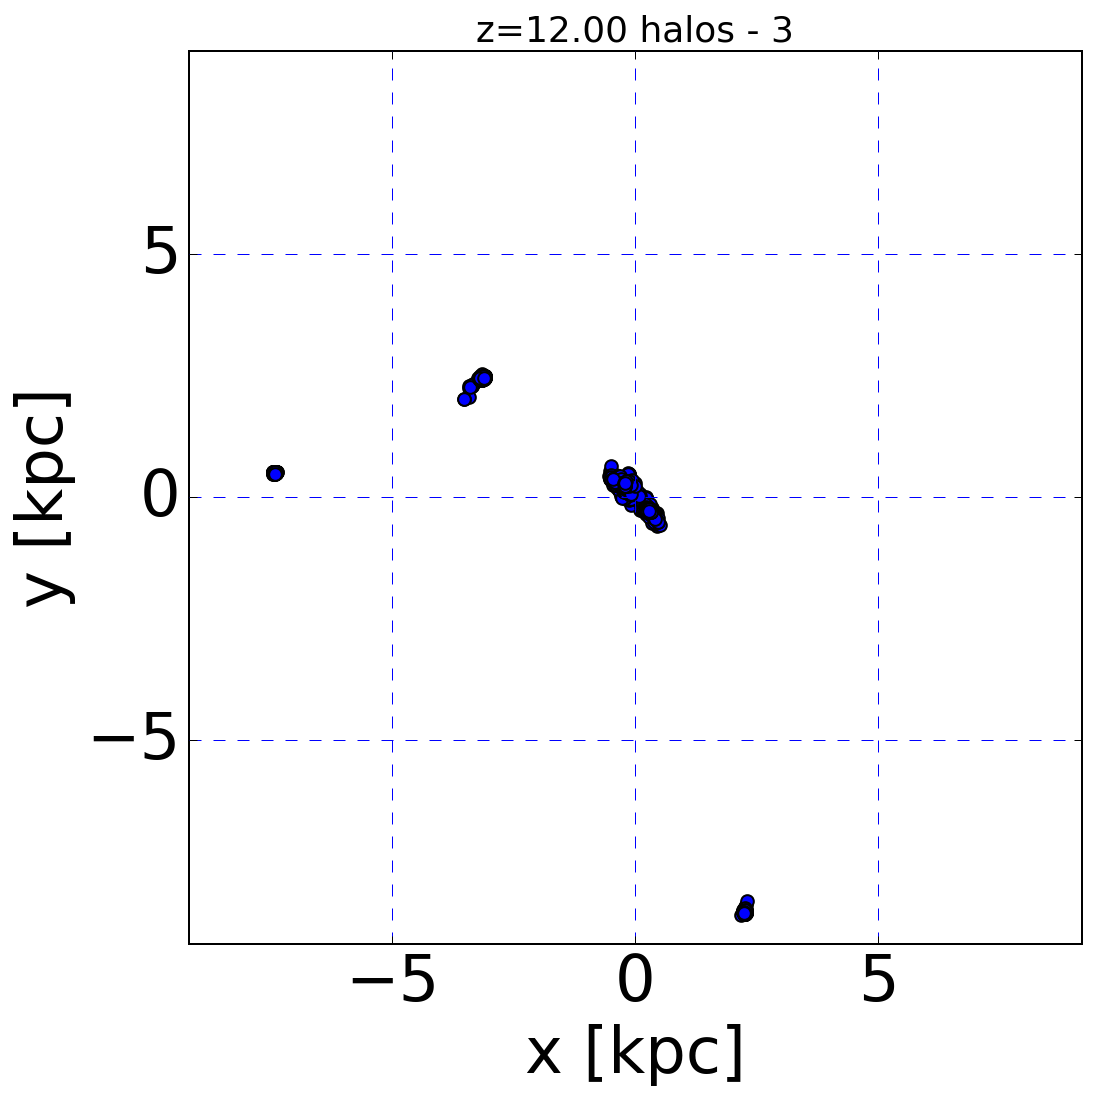

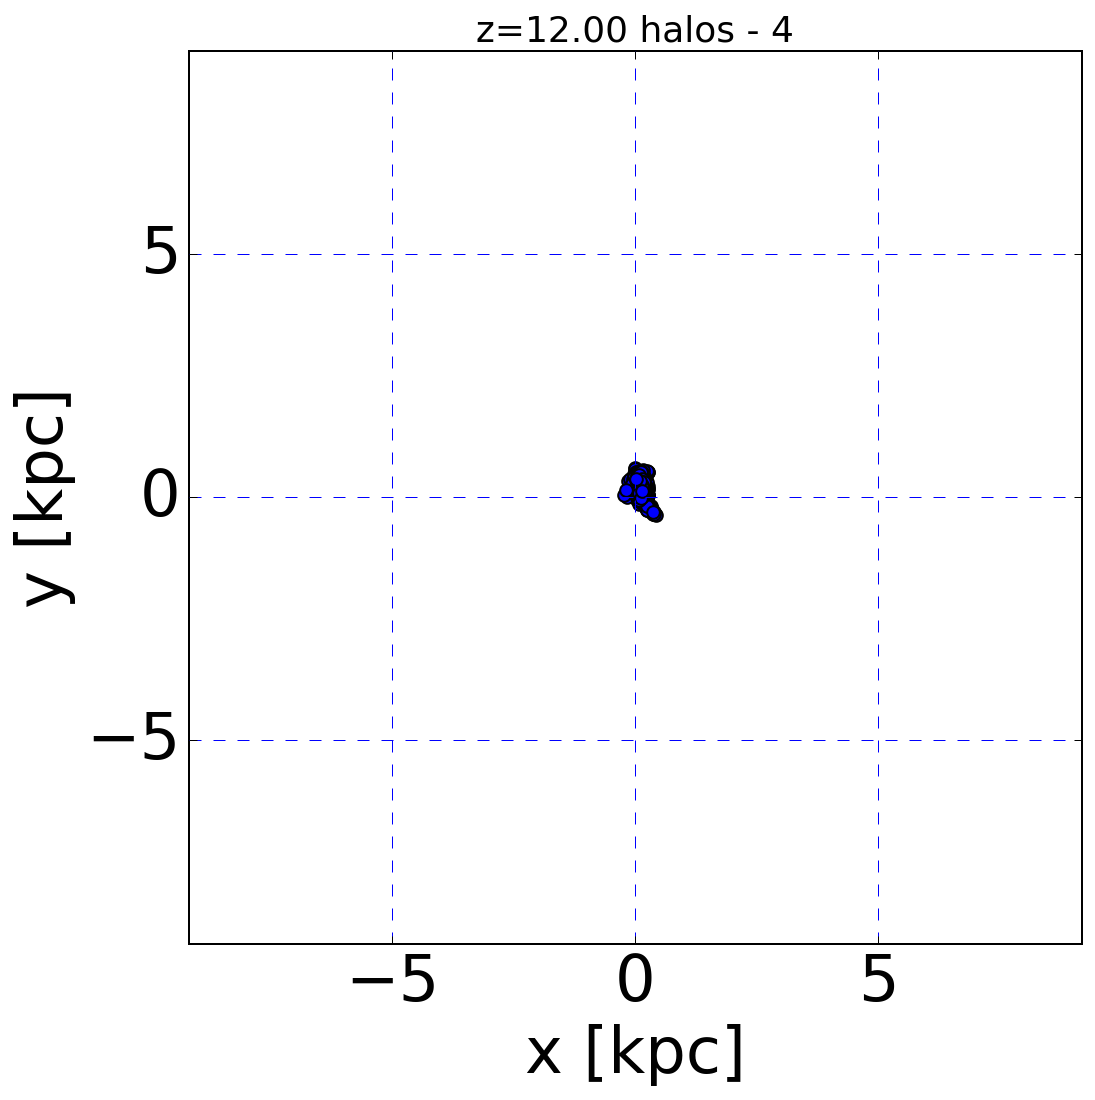

In [55]:
size = 4.0 * u.arcsec / arcPerKpc # Should use cosmology to find kpc for x arcsec... What should I use for x?
size = size.value
print("{} = {}".format(size * u.kpc,size * u.kpc* arcPerKpc))

for haloNum in range(0,5):
    # Load the stars for this halo
    halosplocs,halospmass,halospages,halospZ,halospPZ,halospPPF = halos.getViewStars(locs,mass,spAges,Z,PZ,PPF,
                                                                          halosPos,haloNum,size)
    print("Num {}, Tot Mass {}".format(len(halospmass),halospmass.sum() * u.solMass))

    fig = plt.figure(figsize=(8,8))
    ax = fig.gca()
    ax.scatter(halosplocs[:,0],halosplocs[:,1],s=40,c='b') # Plot star particles
    ax.grid(b=True, which='major', color='b', linestyle='--')
    ax.set_xlabel('x [kpc]')
    ax.set_ylabel('y [kpc]')
    ax.set_title('z=%.2lf halos - %d'%(z,haloNum),size=18)
    ax.set_xlim([-size/2,size/2])
    ax.set_ylim([-size/2,size/2])
    
gc.collect()

In [64]:
print(size)
print(ma.sqrt((size/2.0)**2 * 3.0))

18.3727157717
15.9112385948


In [92]:
reload(halos)

<module 'halos' from '/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules/halos.py'>

In [56]:
viewsplocs,viewspmass,viewspages,viewspZ,viewspPZ,viewspPPF = halos.getViewStars(locs,mass,spAges,Z,PZ,PPF,
                                                                          halosPos,4,size)
halosplocs,halospmass,halospages,halospZ,halospPZ,halospPPF = halos.getHaloStars(locs,mass,spAges,Z,PZ,PPF,
                                                                          halosPos,4,size/2.0)


In [57]:
(rx,ry,rz) = halosPos[0]    # Coordinates of the halo of interest
coords     = -halosPos[0]   # Used for translating coords...

# Find a radius that encompasses a cube with side len 's'
sideLen  = size/2.0             # Compute how far to look in each direction from center of halo
centrd   = locs + coords        # (0,0) is now the center of the halo
centrd2D = centrd[::,[0,1]]     # Just keep 2D data... 

cond = ((np.abs(centrd2D[::,0]) <= sideLen) & (np.abs(centrd2D[::,1]) <= sideLen))
viewStars = centrd[cond] # Note that we're getting 0 centered coords
viewmass  = mass[cond]
viewages  = spAges[cond]
viewZ     = Z[cond]
viewPZ    = PZ[cond]
viewPPF   = PPF[cond]

print(sideLen)

9.186357885868821


In [58]:
r = size/2.0

(rx,ry,rz) = halosPos[0]    # Coordinates of the halo of interest
coords     = -halosPos[0]   # Used for translating coords...

# Find a radius that encompasses a cube with side len 's'
radius = ma.sqrt(r**2 * 3.0) # Compute a radius that's bigger than a cube with side s
centrd = locs + coords
dists = np.linalg.norm(centrd,axis=1)
haloStars = centrd[dists <= radius]
halomass  = mass[dists <= radius]
haloages  = spAges[dists <= radius]
haloZ     = Z[dists <= radius]
haloPZ    = PZ[dists <= radius]
haloPPF   = PPF[dists <= radius]

print(radius)

15.911238594835815


In [59]:
len(viewmass),len(halomass)

(5489, 5135)

# Plot halo-specific histograms

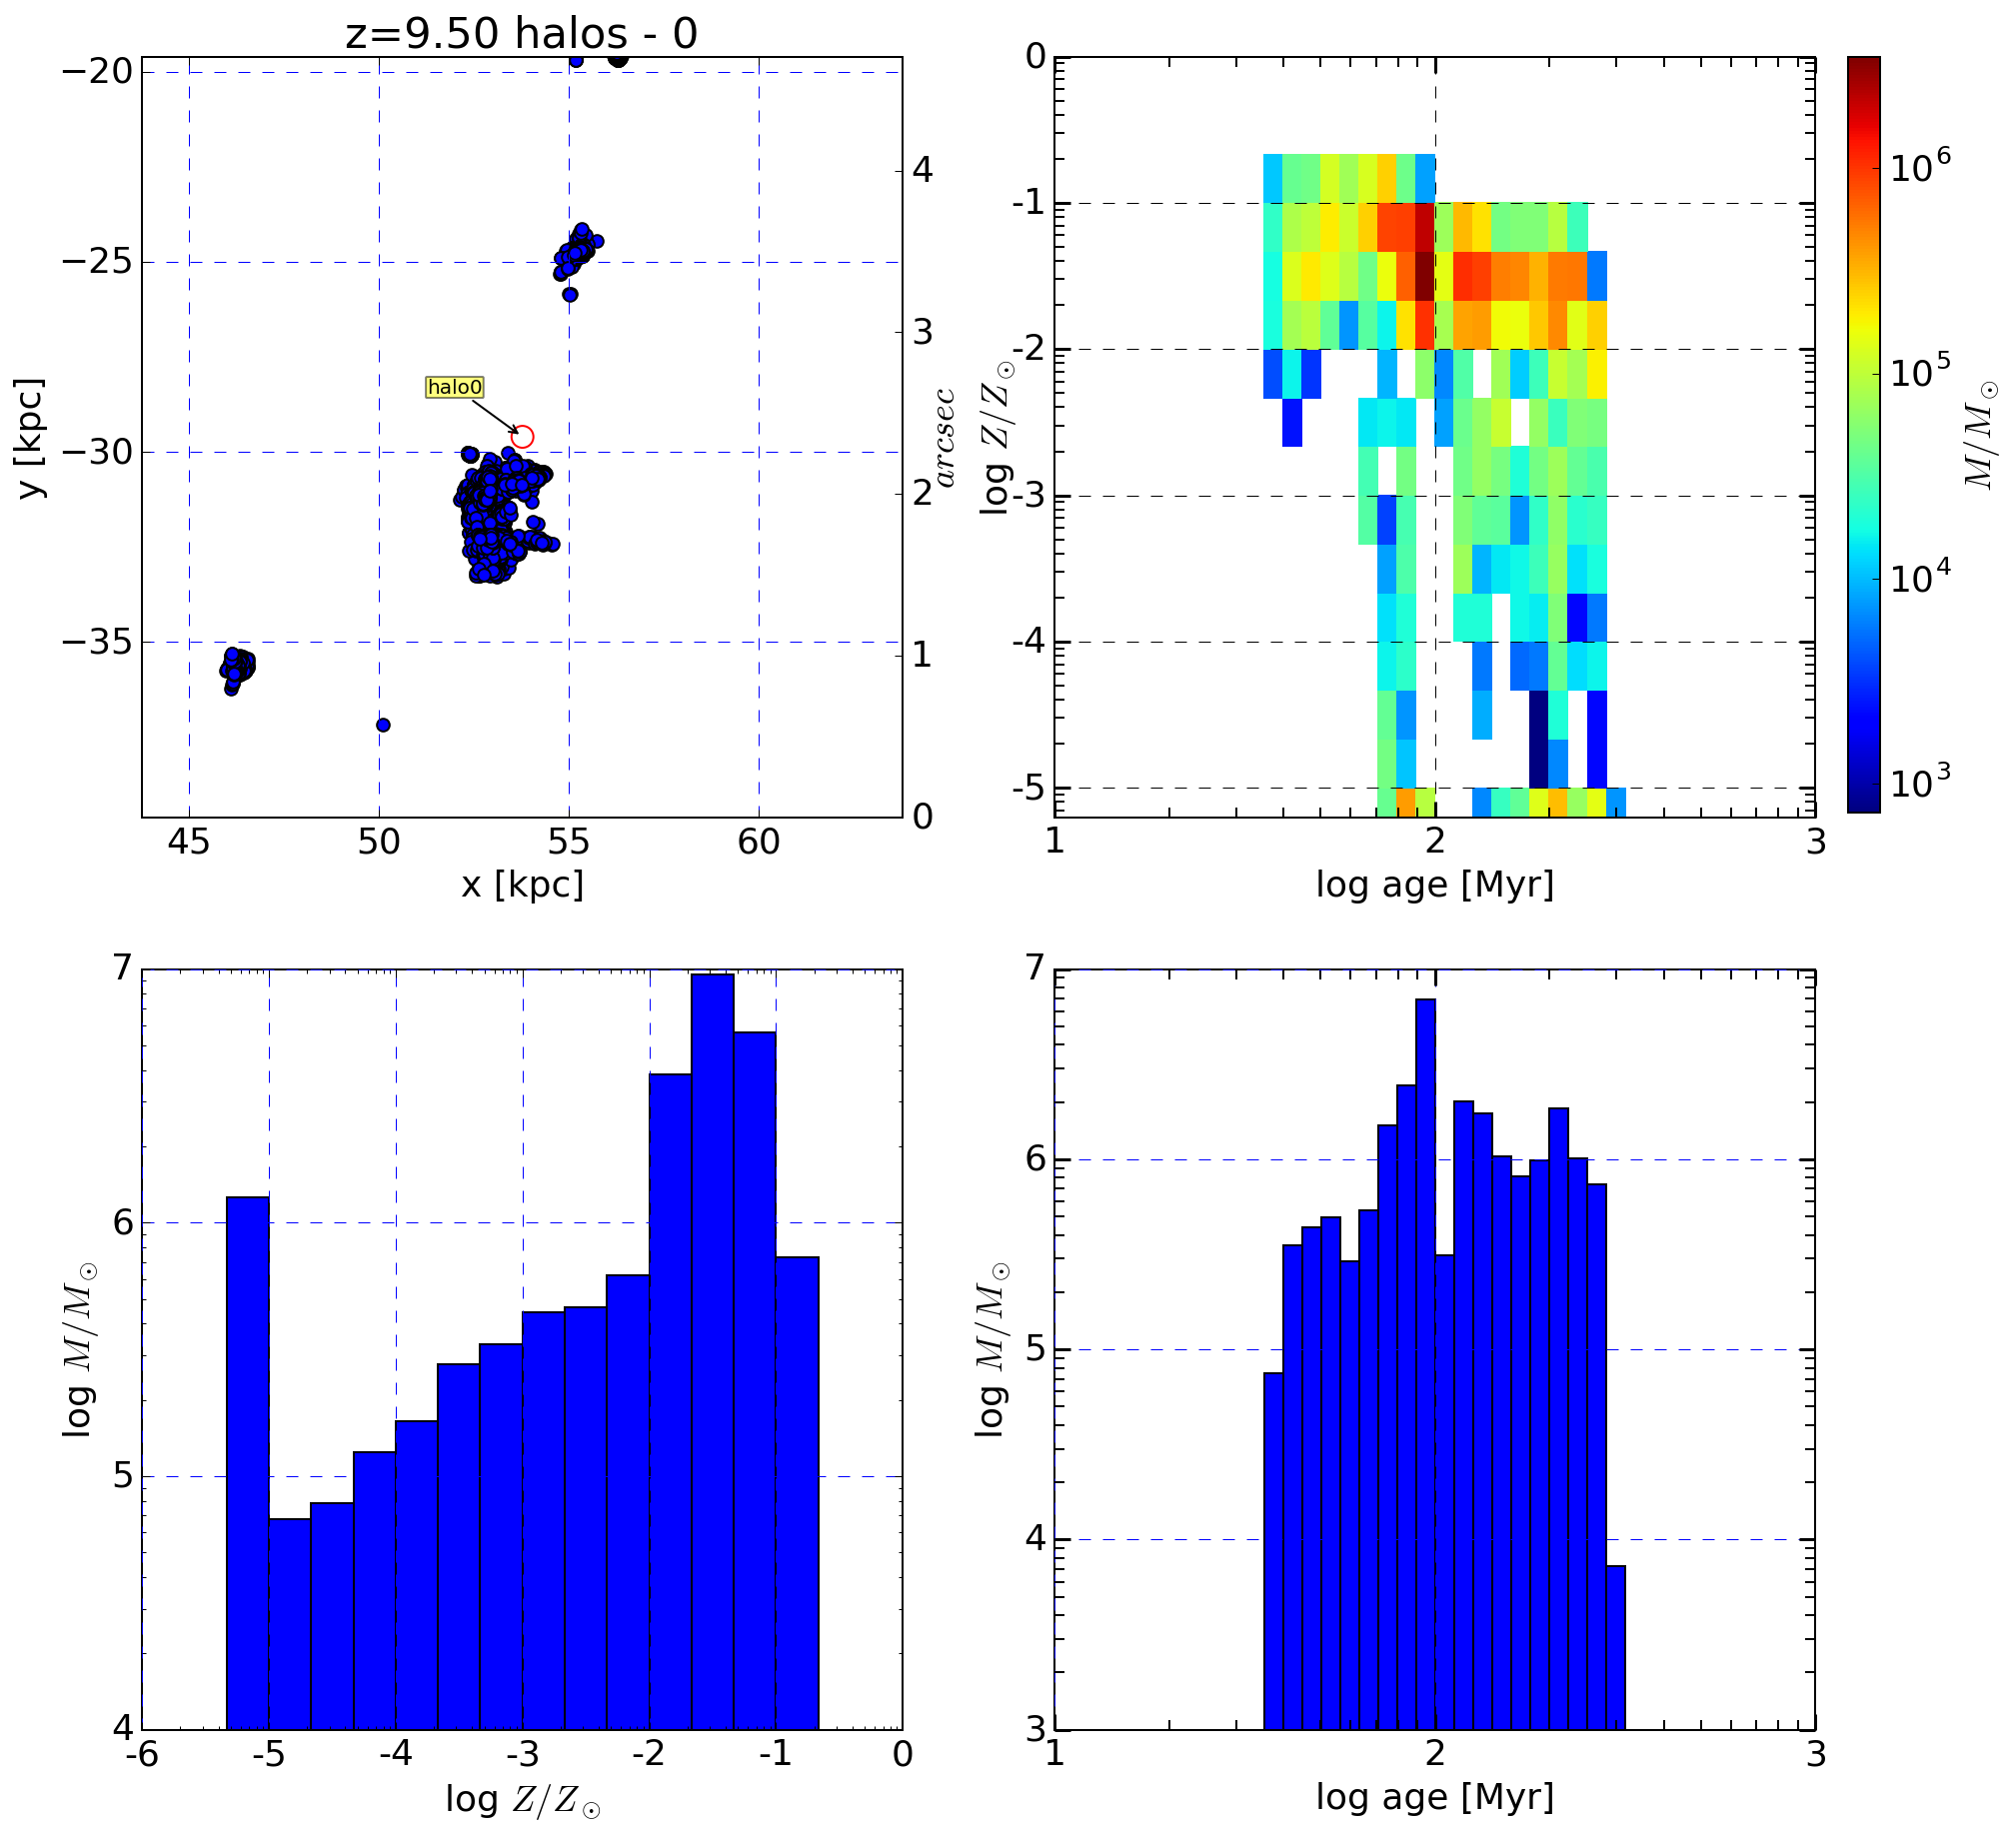

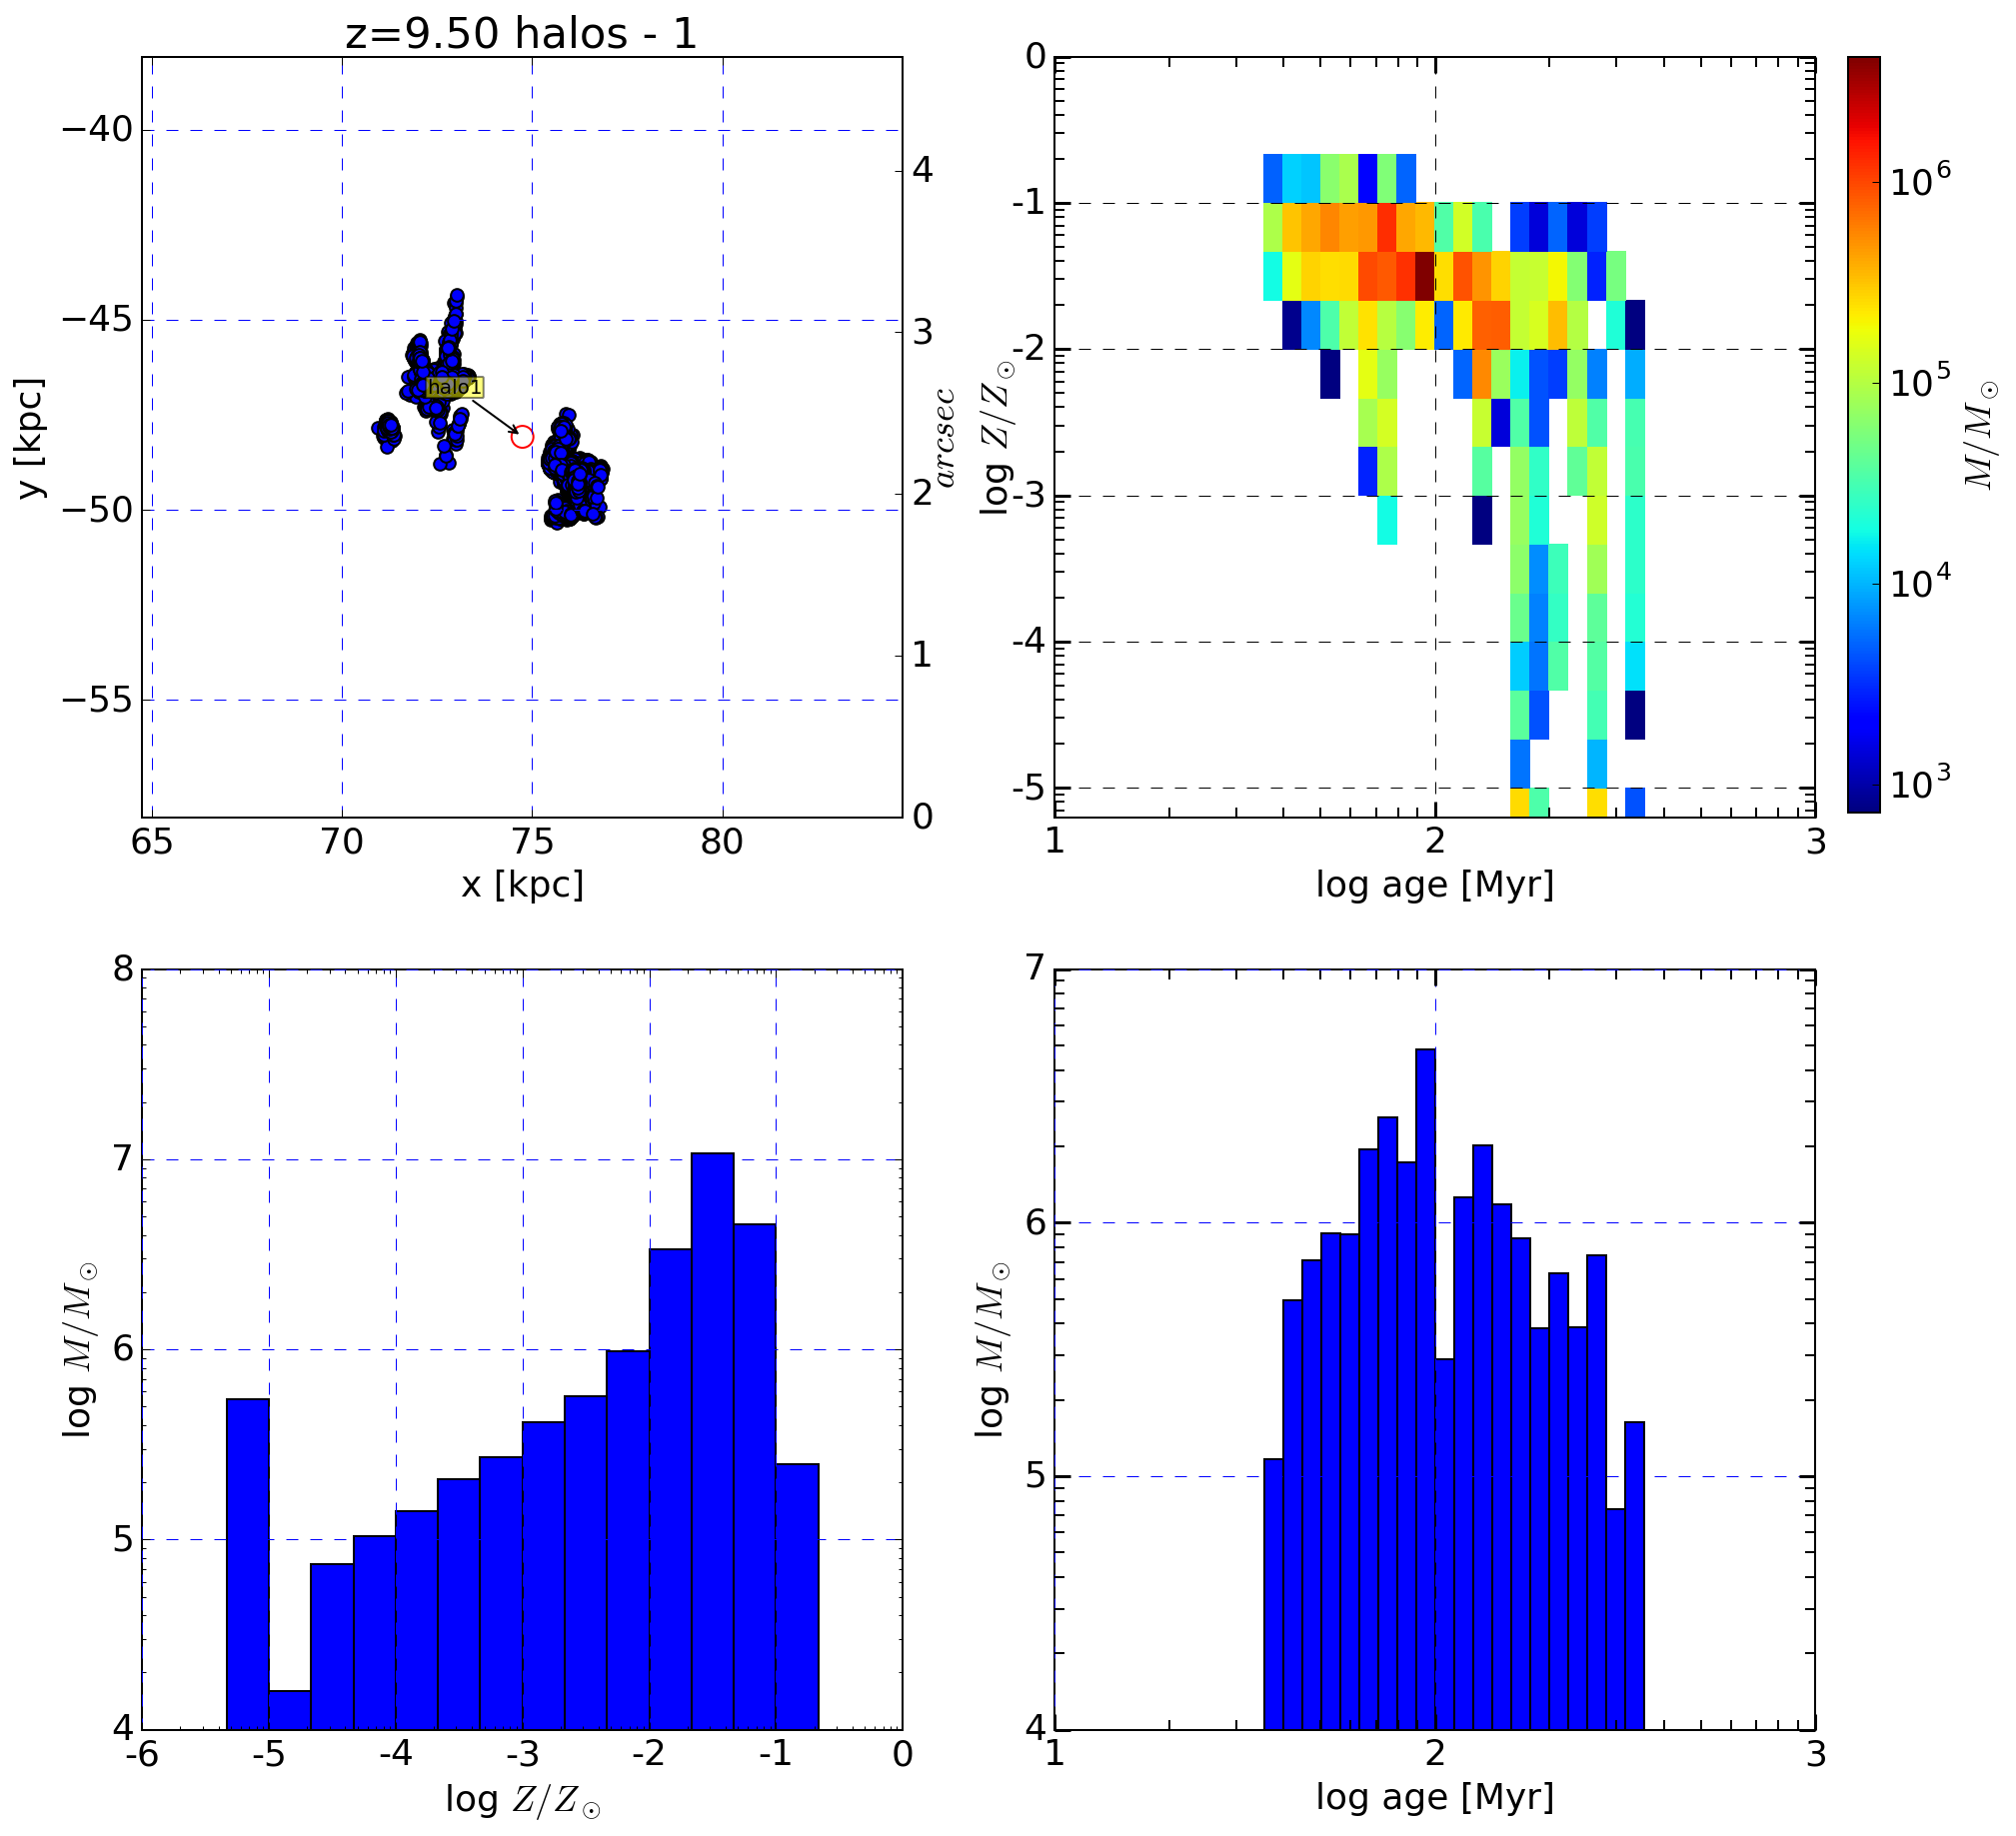

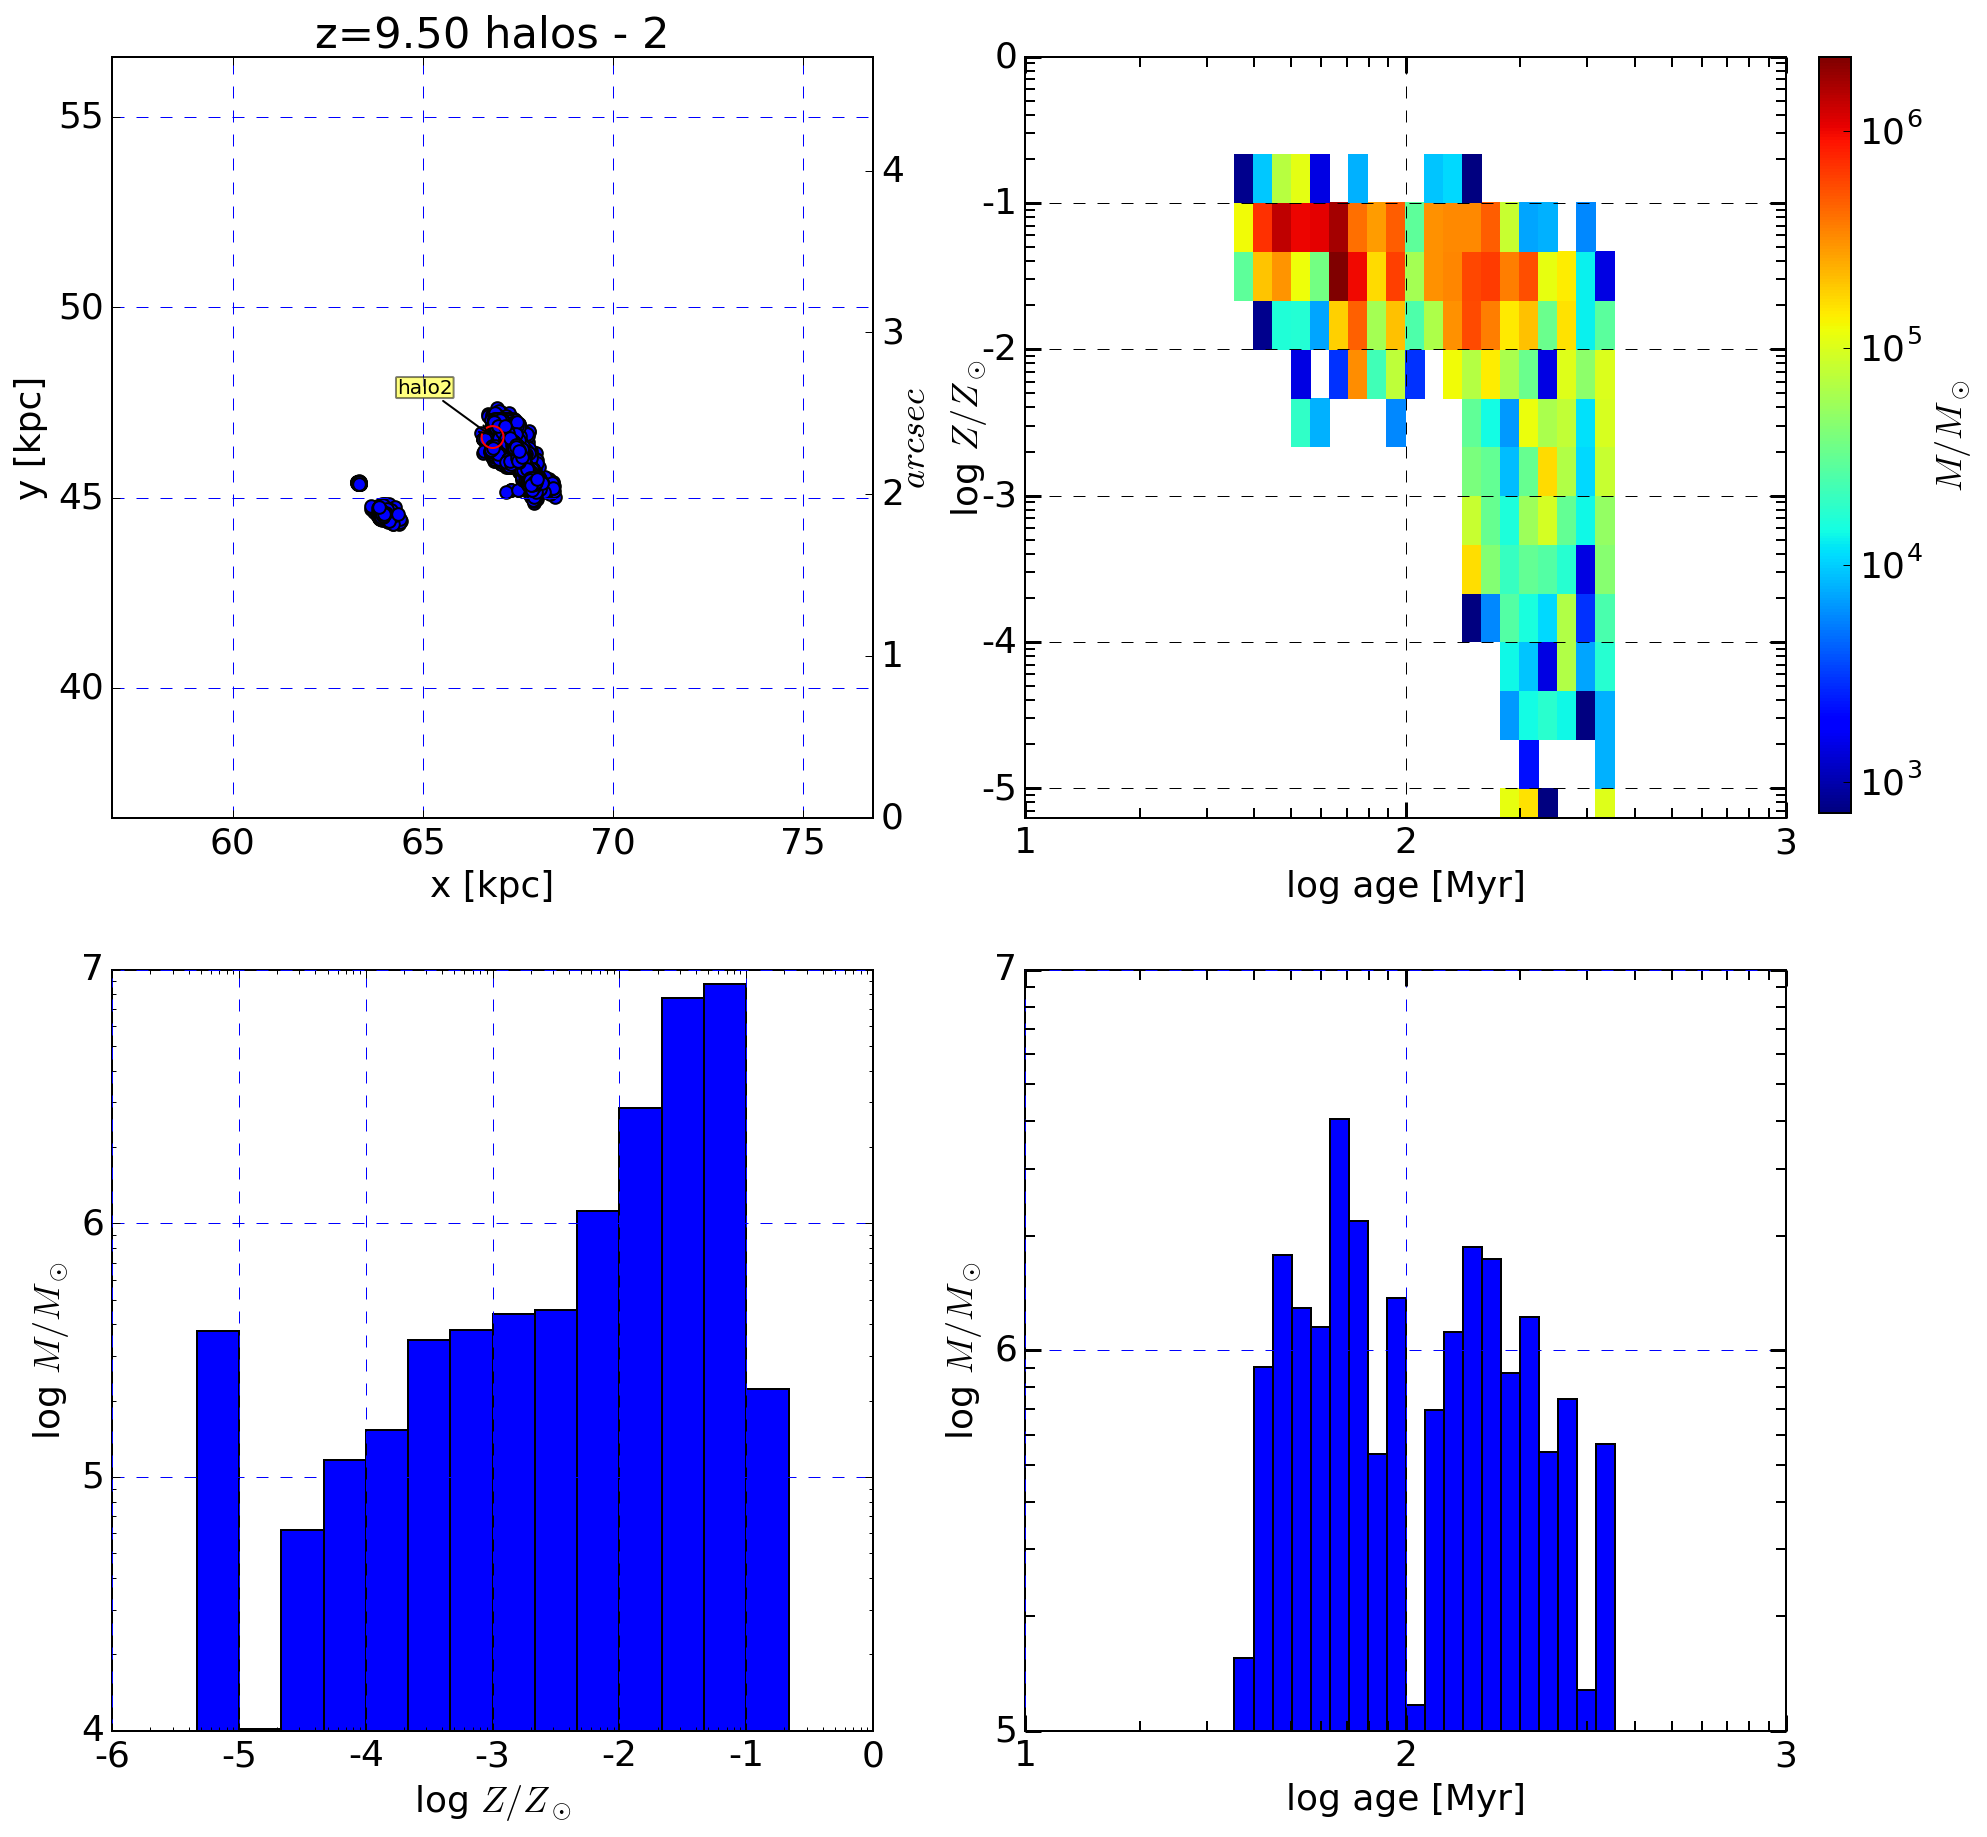

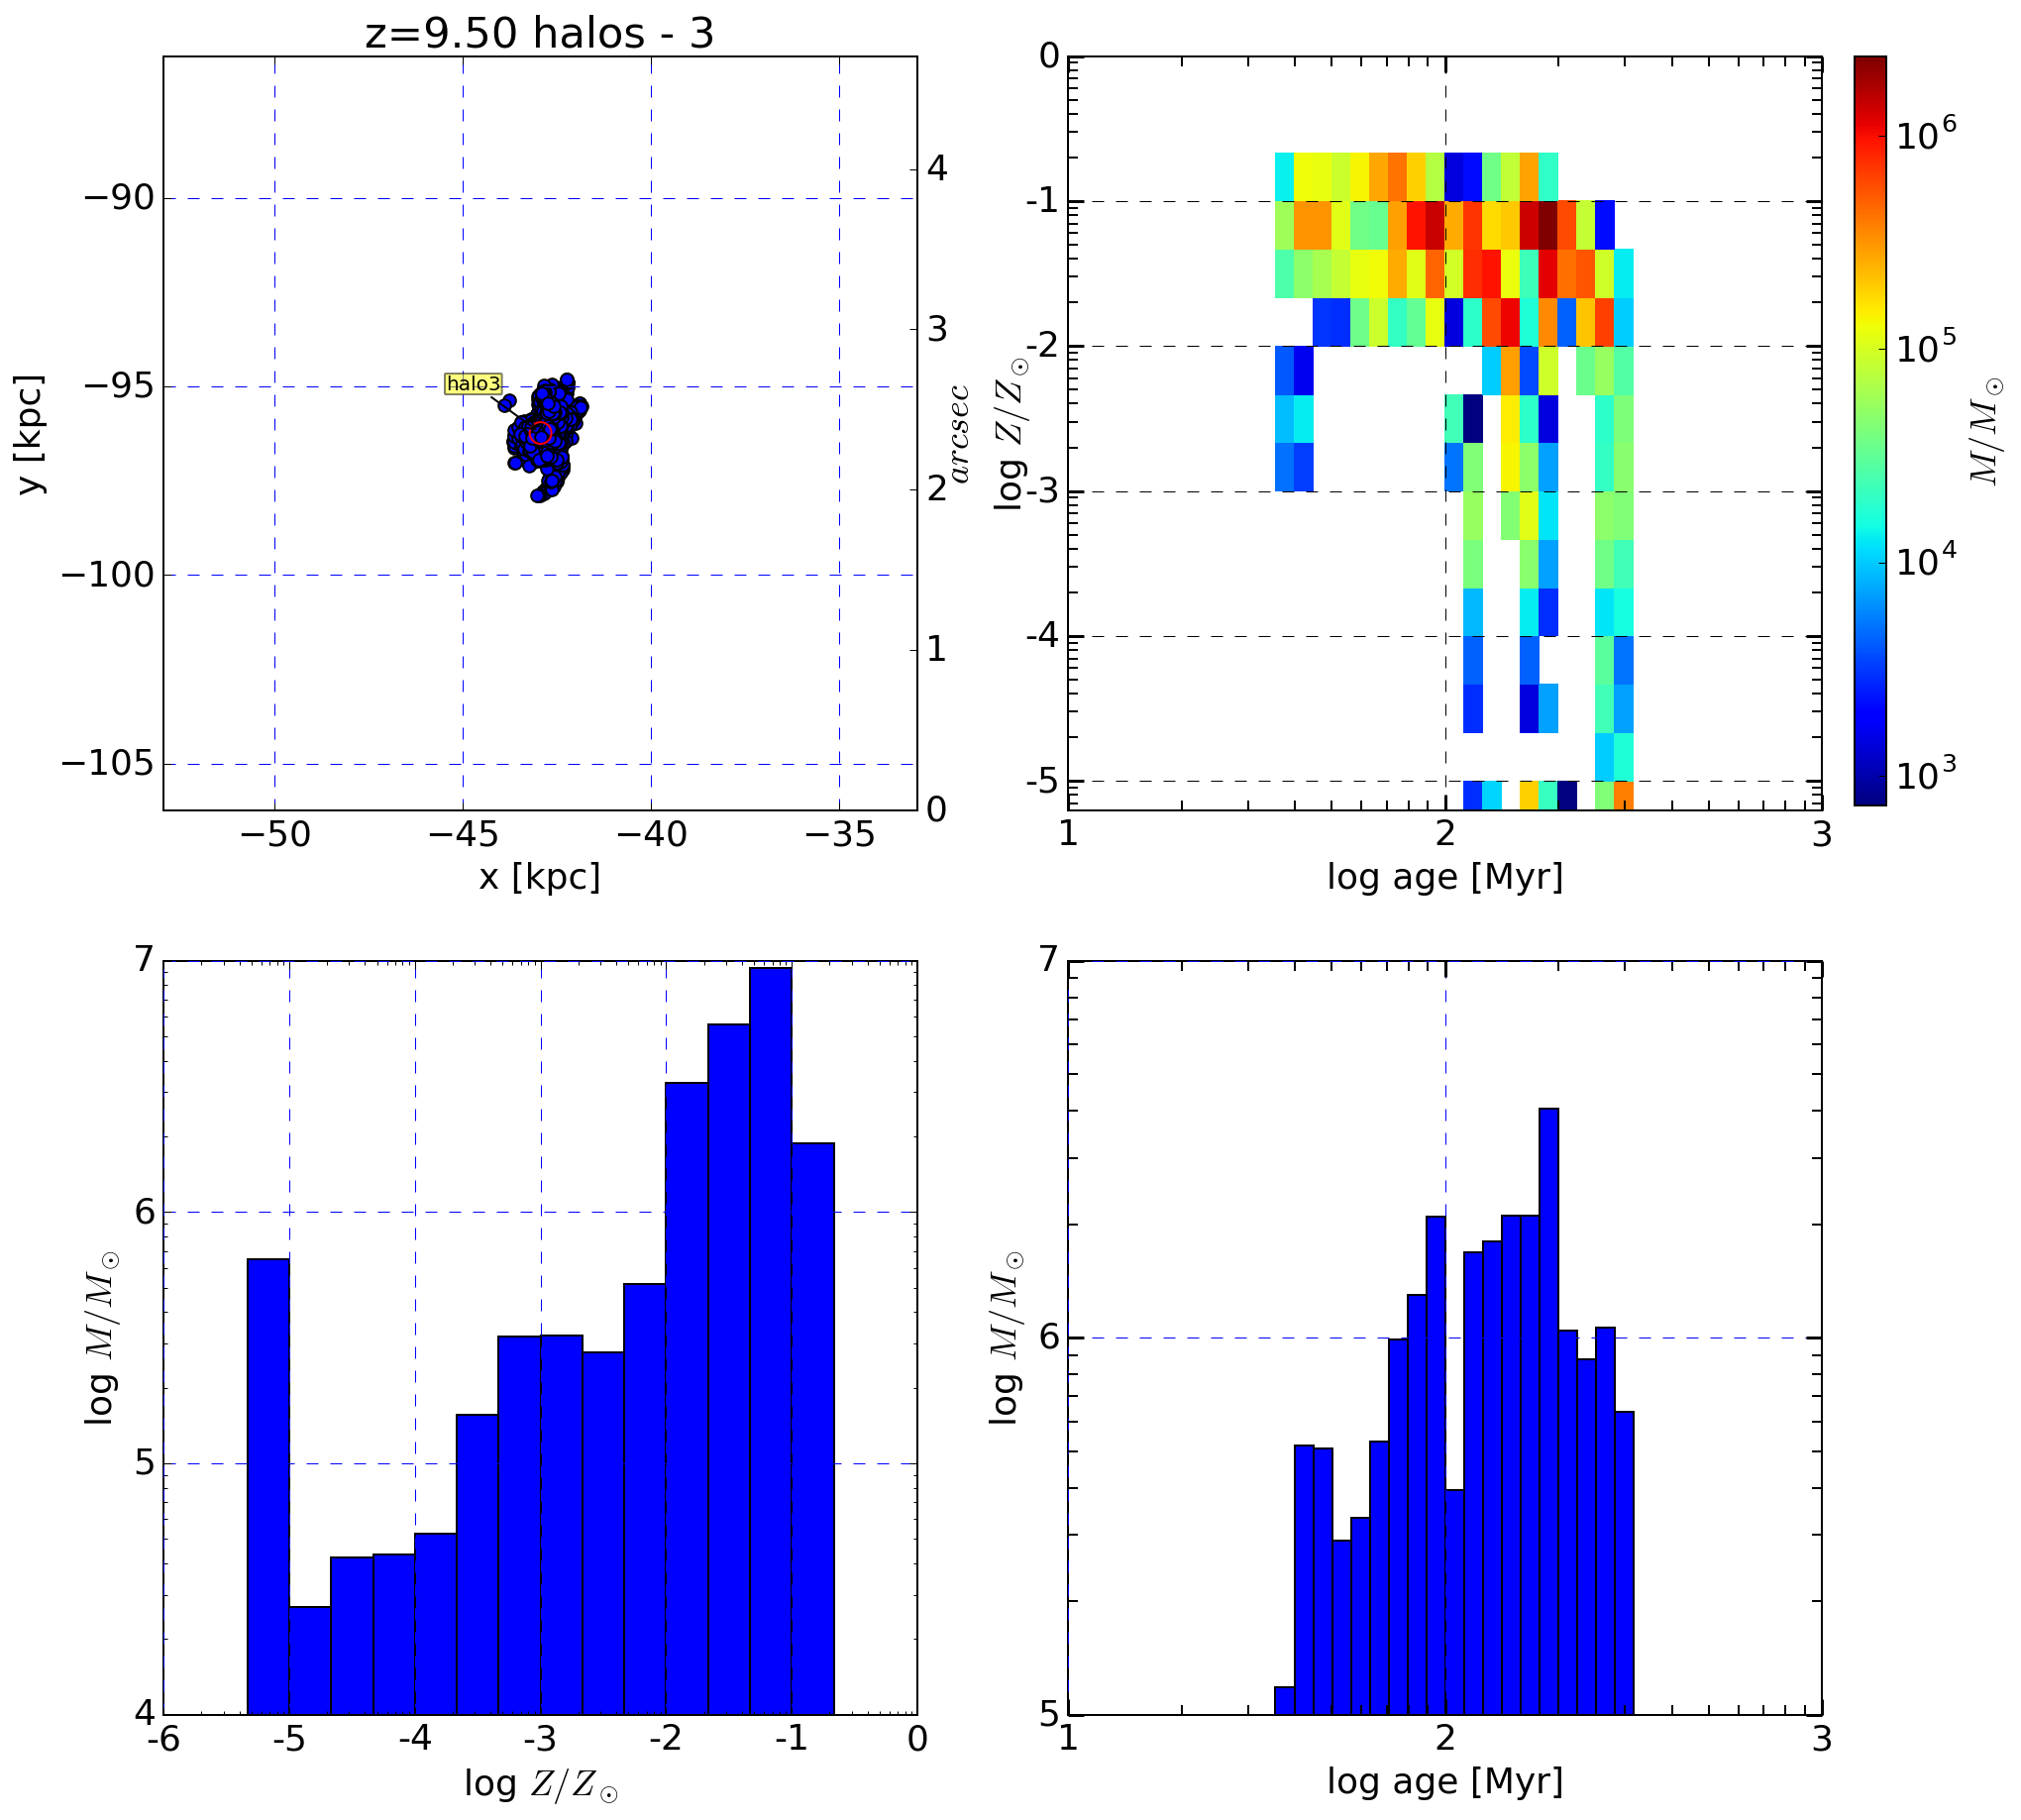

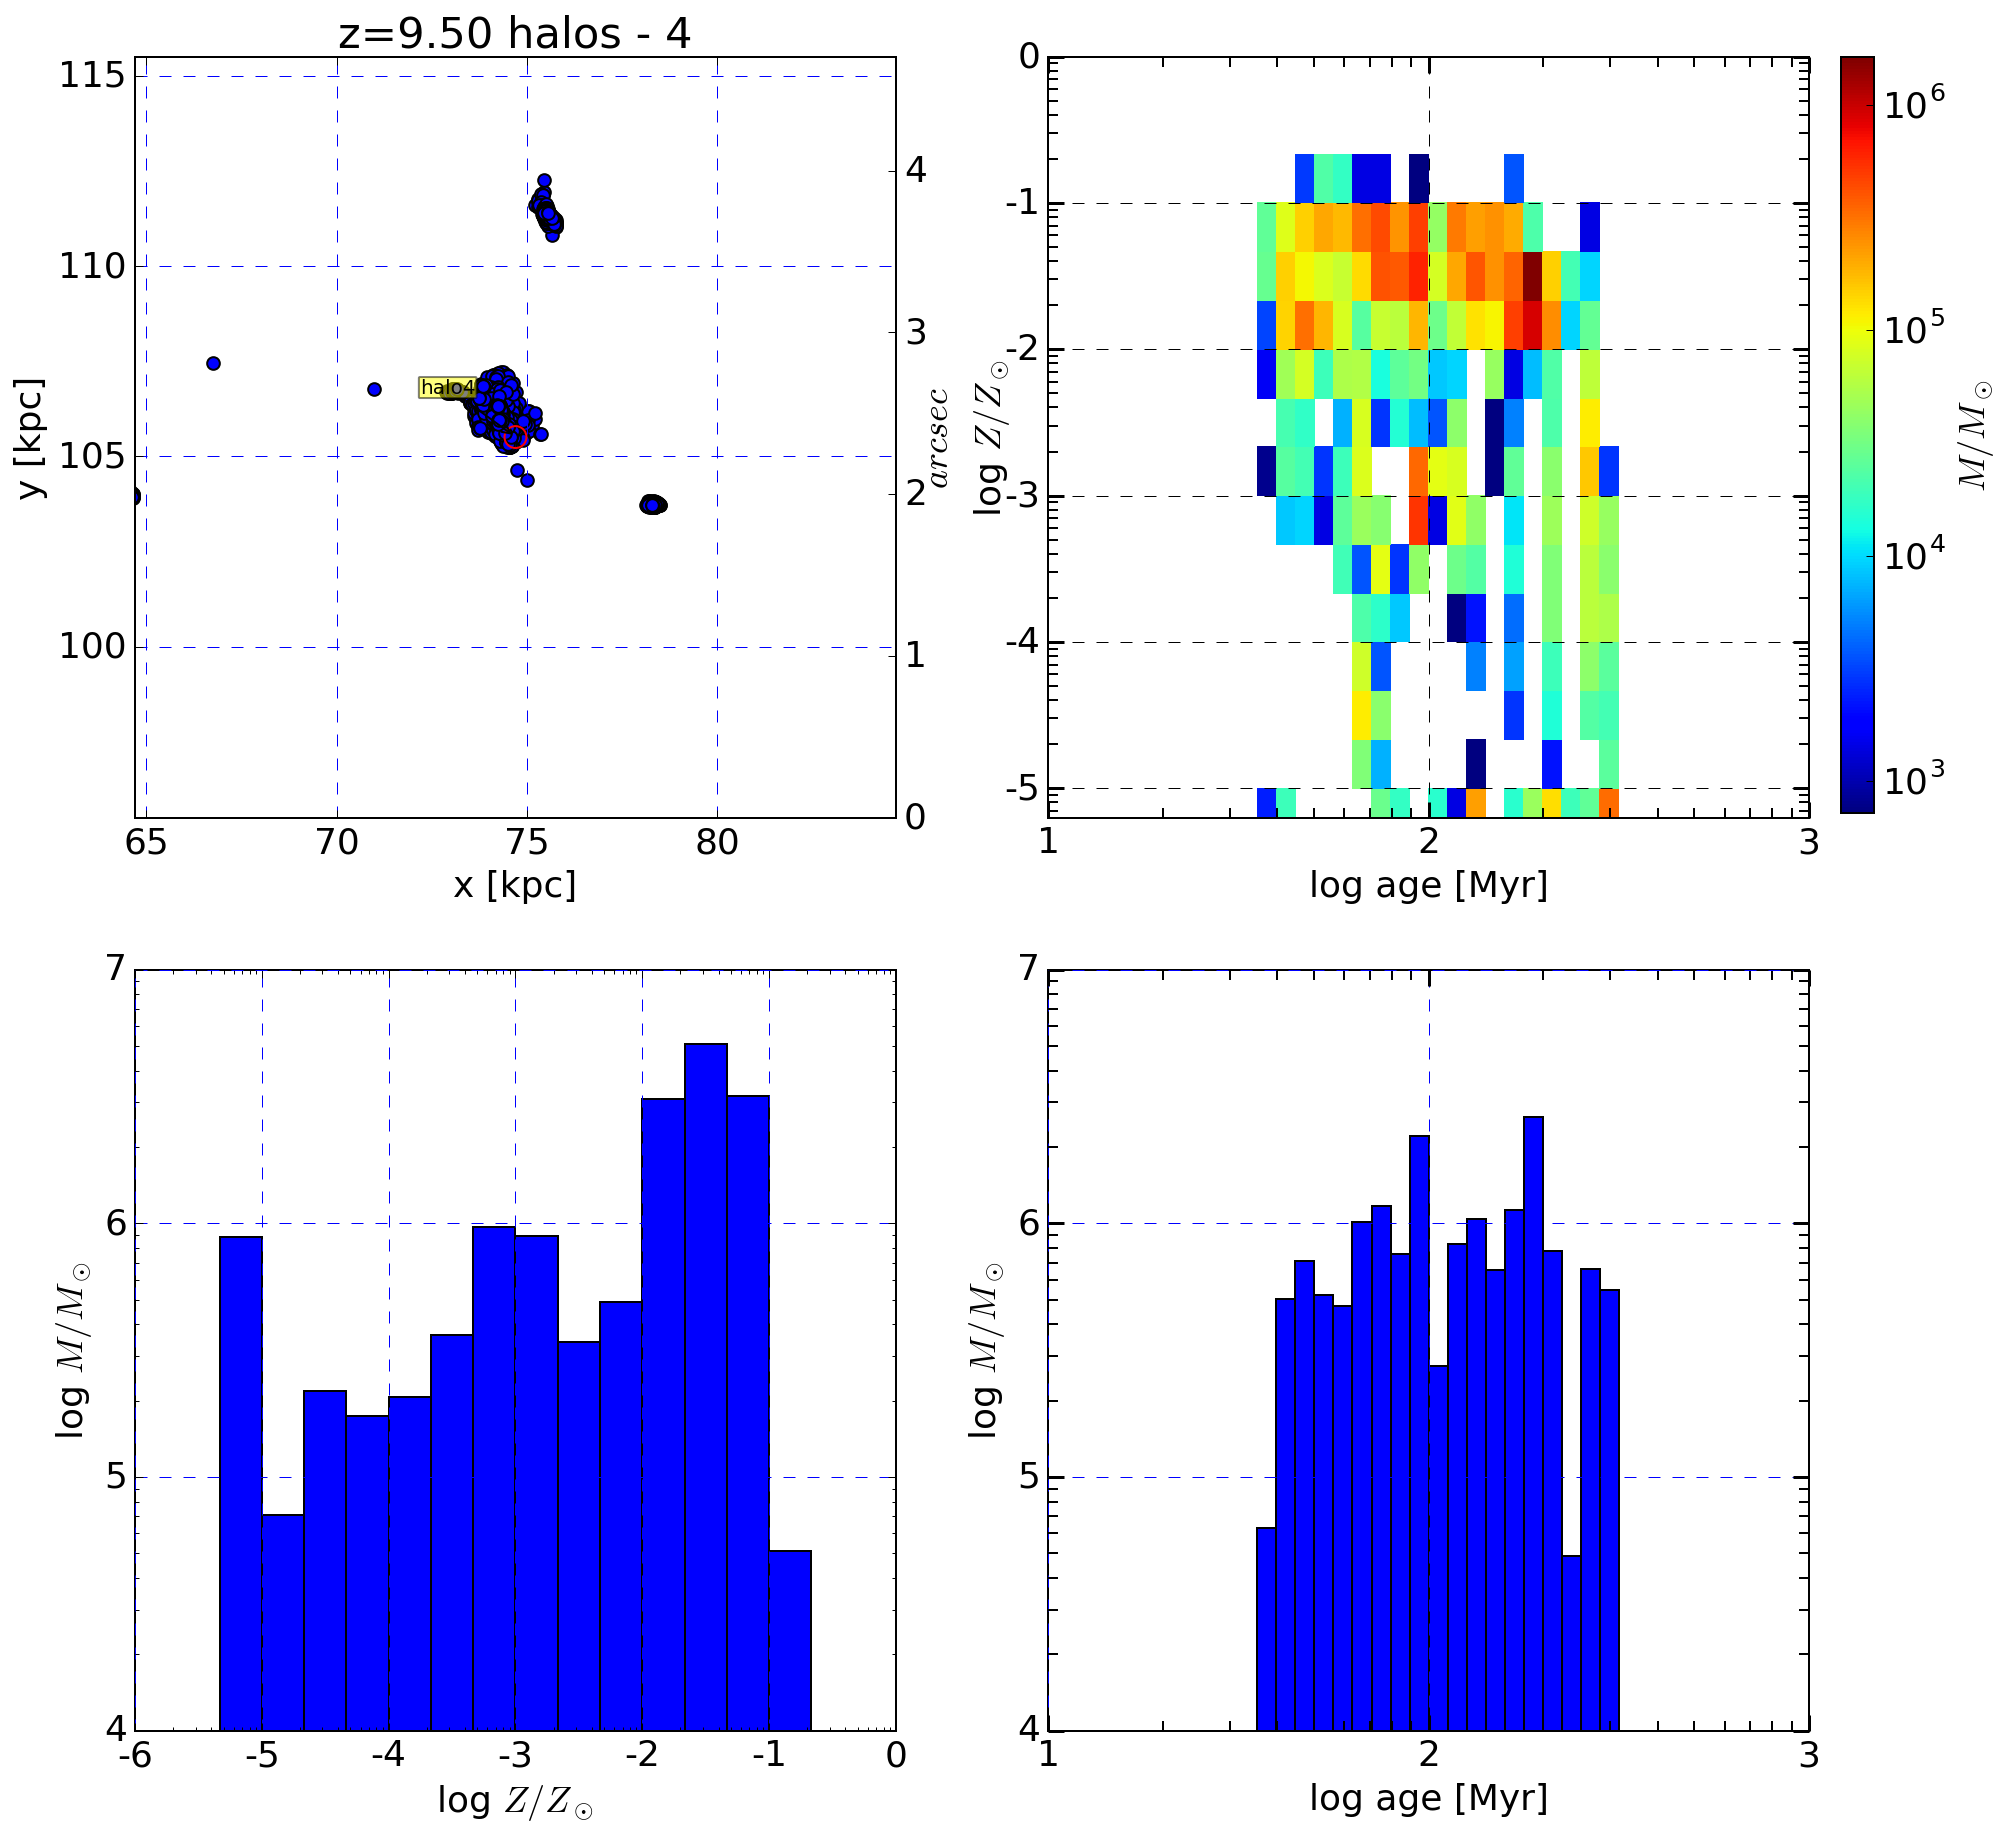

In [165]:
plt.rcParams['font.size'] = 18
cmap = plt.cm.jet
for haloNum in range(0,5):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(15, 15))
    #
    # Star particles for halo haloNum
    #

    arcSec = cosmo.arcAtz(71,z)

    #
    # Plot the halo star particles - scatter
    #
    size = 20
    hax=halos.pltHalo(locs,halosPos,haloNum,z,size,ax=ax1)
    origXlim=hax.get_xlim()
    origYlim=hax.get_ylim()

    # Add axis with arcsec scale
    hax2 = hax.twinx()
    hax2.set_ylim([0,size/arcSec])
    hax2.set_ylabel(r'$arcsec$')
    hax2.yaxis.labelpad = -3
    hax.set_xlim(origXlim)
    hax.set_ylim(origYlim)

    # Load the stars for this halo
    haloStars,halomass,haloages,haloZ,haloPZ,haloPPF = halos.getHaloStars(locs,mass,ages,Z,PZ,PPF,
                                                                          halosPos,haloNum,size)

    #
    # Metallicity of the halo star particles - histogram
    #
    Zfixed = haloZ
    Zfixed[Zfixed < 1e-5] = 10**-5.1

    ZBins   = np.logspace(-6,0,19)
    ax3.hist(Zfixed,bins=ZBins,weights=halomass)
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.xaxis.set_major_formatter(logfmt)
    ax3.yaxis.set_major_formatter(logfmt)
    ax3.grid(b=True, which='major', color='b', linestyle='--')
    ax3.set_xlabel(r'log $Z/Z_\odot$')
    ax3.set_ylabel(r'log $M/M_\odot$')

    #
    # Age of halo star particles - histogram
    #
    ageBins = np.logspace(0,3,61) # TO match the SEDs we have from Schaerer, use 0.05 dex steps

    n, bins, patches = ax4.hist(haloages,bins=ageBins, weights=halomass)
    ax4.set_xscale('log')
    ax4.set_yscale('log')
    ax4.xaxis.set_major_formatter(logfmt)
    ax4.yaxis.set_major_formatter(logfmt)
    ax4.grid(b=True, which='major', color='b', linestyle='--')
    ax4.tick_params('both', length=5, width=1, which='minor')
    ax4.tick_params('both', length=8, width=1.5, which='major')
    ax4.set_xlabel('log age [Myr]')
    ax4.set_ylabel(r'log $M/M_\odot$')
    ax4.set_xlim([10,1000])
    
    #
    # 2D histogram, Z vs age
    #
    ageBins = np.logspace(0,3,61) # match the SEDs we have from Schaerer, use 0.05 dex steps
    ZBins   = np.logspace(-6,0,19)

    Zfixed = haloZ
    Zfixed[Zfixed < 1e-5] = 10**-5.1

    # Can't use matplotlib with log axis... is screws it up.
    # n, aBins, metBins, image = ax.hist2d(ages,Zfixed,bins=(ageBins,ZBins),norm=LogNorm(),
    #                                    weights=mass)
    # Need to use numpy...
    n, aBins, metBins = np.histogram2d(Zfixed,haloages,bins=(ZBins,ageBins),
                                            weights=halomass)
    histax = ax2.pcolormesh(ageBins, ZBins, n, norm=LogNorm())

    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.xaxis.set_major_formatter(logfmt)
    ax2.yaxis.set_major_formatter(logfmt)
    ax2.grid(b=True, which='major', color='k', linestyle='--')
    ax2.tick_params('both', length=5, width=1, which='minor')
    ax2.tick_params('both', length=8, width=1.5, which='major')
    ax2.set_xlabel(r'log age [Myr]')
    ax2.set_ylabel(r'log $Z/Z_\odot$')
    ax2.set_xlim([10,1000])
    ax2.set_ylim([10**-5.2,1])
    cax = fig.add_axes([0.915, 0.55, 0.015, 0.35])
    fig.colorbar(histax, cax=cax, label="$M/M_\odot$")
    ax2.yaxis.labelpad = -4

    #plt.subplots_adjust(left=0.15, bottom=0.1, right=0.84, top=.95, wspace=.1, hspace=.1)


In [191]:
# Looks correct ... for halo4 the total in the range below should be in the orange
np.log10(halomass[(Zfixed==10**-5.1) & (haloages >= 10**2.45) & (haloages <= 10**2.50)].sum())

5.5253340771582877

In [7]:
# Numpy histograms include left edge, but not right unless it is the final bin...
conditions = np.empty([19,61])
for indxz, az in enumerate(np.logspace(-6,0,19)):
    for indxa, aa in enumerate(np.logspace(0,3,61)):
        conditions[indxz,indxa] = 

1e-06
2.15443469003e-06
4.64158883361e-06
1e-05
2.15443469003e-05
4.64158883361e-05
0.0001
0.000215443469003
0.000464158883361
0.001
0.00215443469003
0.00464158883361
0.01
0.0215443469003
0.0464158883361
0.1
0.215443469003
0.464158883361
1.0


In [14]:
for ind, a in enumerate(np.linspace(0,5,6)):
    print(ind,a)

0 0.0
1 1.0
2 2.0
3 3.0
4 4.0
5 5.0


In [11]:
conditions[0]

array([  0.00000000e+000,   0.00000000e+000,   2.17645492e-314,
         2.17645491e-314,   2.17645491e-314,   2.17645490e-314,
         2.17645490e-314,   2.17645489e-314,   2.17645488e-314,
         2.17645488e-314,   2.17645487e-314,   2.17645486e-314,
         2.17645486e-314,   2.17645485e-314,   2.17645484e-314,
         2.17645484e-314,   2.17645483e-314,   2.17645483e-314,
         2.17645482e-314,   2.17645481e-314,   2.17645481e-314,
         2.17645480e-314,   2.17645479e-314,   2.17645479e-314,
         2.17645478e-314,   2.17645477e-314,   2.17645477e-314,
         2.17645476e-314,   2.17645475e-314,   2.17645475e-314,
         2.17645474e-314,   2.17645473e-314,   2.17645473e-314,
         2.17645472e-314,   2.17645471e-314,   2.17645470e-314,
         2.17645470e-314,   2.17645469e-314,   2.17645468e-314,
         2.17645468e-314,   2.17645467e-314,   2.17645466e-314,
         2.17645466e-314,   2.17645465e-314,   2.17645464e-314,
         2.17645463e-314,   2.17645463e-

In [ ]:
plt.rcParams['font.size'] = 32

# To plot star particle locs, we need to center on a halo

In [30]:
# Get only the stars in the halo -- within 40 kpc of the center
haloStars,halomass,haloages, haloZ,haloPZ,haloPPF = halos.getHaloStars(locs,mass,ages,Z,PZ,PPF,halosPos,0,40)

In [31]:
len(haloStars),locs

(35637, array([[ -99.53752334,  -58.6532154 , -104.47938321],
        [ -74.77011246,  -54.62774748, -106.40648134],
        [ -74.76224051,  -54.61064111, -106.39499281],
        ..., 
        [  51.27059985,  -70.77334023, -194.10726276],
        [  51.26832913,  -70.89807074, -194.11447627],
        [  51.27049721,  -70.8407234 , -194.11437167]]))

In [22]:
halofpol = (1-haloPPF)
halofpol[halofpol<1e-7] = 0 # Don't let tiny numbers magnify Z !! Just use Z = 0 for these guys

# Do the correcting before fixing Z for subcritical values... otherwise, we bias Z/f_pol
haloZf=haloZ/halofpol # This is our Z corrected for f_pol
haloZf[np.isinf(haloZf)] = 10**-7.5 # Fix Zf for sp's with very very low polluted fractions. They are essentially pristine
haloZf[np.isnan(haloZf)] = 10**-7.5
haloZf[haloZf<1e-7] = 10**-7.5

haloZ[haloZ<1e-7] = 10**-7.5

haloPZf=haloPZ/halofpol
haloPZf[np.isinf(haloPZf)] = 10**-7.5
haloPZf[np.isnan(haloPZf)] = 10**-7.5
haloPZf[haloPZf<1e-7] = 10**-7.5

haloPZ[haloPZ<1e-7] = 10**-7.5

haloPPF[haloPPF<1e-7] = 10**-7.5

/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in divide
/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in divide


In [23]:
# Pick out stars by metallicity range... 
rng1 = (haloZ < 1.e-5)
rng2 = ((haloZ >= 1.e-5) & (haloZ < 1.e-3))
rng3 = ((haloZ >= 1.e-3) & (haloZ < 1.e-1))
rng4 = (haloZ >= 1.e-1)

# Pick out stars by corrected metallicity range... 
rngf1 = (haloZf < 1.e-5)
rngf2 = ((haloZf >= 1.e-5) & (haloZf < 1.e-3))
rngf3 = ((haloZf >= 1.e-3) & (haloZf < 1.e-1))
rngf4 = (haloZf >= 1.e-1)

# Pick out stars by pristine fraction, in ranges... 
pfrng1 = (haloPPF < 1.e-5)
pfrng2 = ((haloPPF >= 1.e-5) & (haloPPF < 1.e-3))
pfrng3 = ((haloPPF >= 1.e-3) & (haloPPF < 1.e-1))
pfrng4 = (haloPPF >= 1.e-1)

pzrng1 = (haloPZ < 1.e-5)
pzrng2 = ((haloPZ >= 1.e-5) & (haloPZ < 1.e-3))
pzrng3 = ((haloPZ >= 1.e-3) & (haloPZ < 1.e-1))
pzrng4 = (haloPZ >= 1.e-1)

pzrngf1 = (haloPZf < 1.e-5)
pzrngf2 = ((haloPZf >= 1.e-5) & (haloPZf < 1.e-3))
pzrngf3 = ((haloPZf >= 1.e-3) & (haloPZf < 1.e-1))
pzrngf4 = (haloPZf >= 1.e-1)

In [24]:
z1=np.log10(haloZ[rng1])
z2=np.log10(haloZ[rng2])
z3=np.log10(haloZ[rng3])
z4=np.log10(haloZ[rng4])

zf1=np.log10(haloZf[rngf1]) # zf is the corrected Z of the star particle
zf2=np.log10(haloZf[rngf2])
zf3=np.log10(haloZf[rngf3])
zf4=np.log10(haloZf[rngf4])

pf1=np.log10(haloPPF[pfrng1])
pf2=np.log10(haloPPF[pfrng2])
pf3=np.log10(haloPPF[pfrng3])
pf4=np.log10(haloPPF[pfrng4])

pz1=np.log10(haloPZ[pzrng1])
pz2=np.log10(haloPZ[pzrng2])
pz3=np.log10(haloPZ[pzrng3])
pz4=np.log10(haloPZ[pzrng4])

pzf1=np.log10(haloPZf[pzrngf1])
pzf2=np.log10(haloPZf[pzrngf2])
pzf3=np.log10(haloPZf[pzrngf3])
pzf4=np.log10(haloPZf[pzrngf4])

In [28]:
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(ii) for ii in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5,.5,.5,1.0)
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(-7.5,0,16)
ticks  =[-7,-6,-5,-4,-3,-2,-1,0]
norm   = mpl.colors.BoundaryNorm(bounds, cmap.N)

dotNorm = 10

In [26]:
sbox,haloStars

(14.2, array([[ -5.1416369 ,  -2.32161234,   4.22503227],
        [ -6.95167407,  -2.82840801,   5.35873524],
        [ -6.80296447,  -2.44317117,   5.12823459],
        ..., 
        [ -2.55907146, -32.50926903,   6.50834822],
        [ -2.53041257, -32.38322651,   6.63678223],
        [ -2.42795067, -32.22299523,   6.71380691]]))



(-7.0999999999999996, 7.0999999999999996)
-14.2
14.2


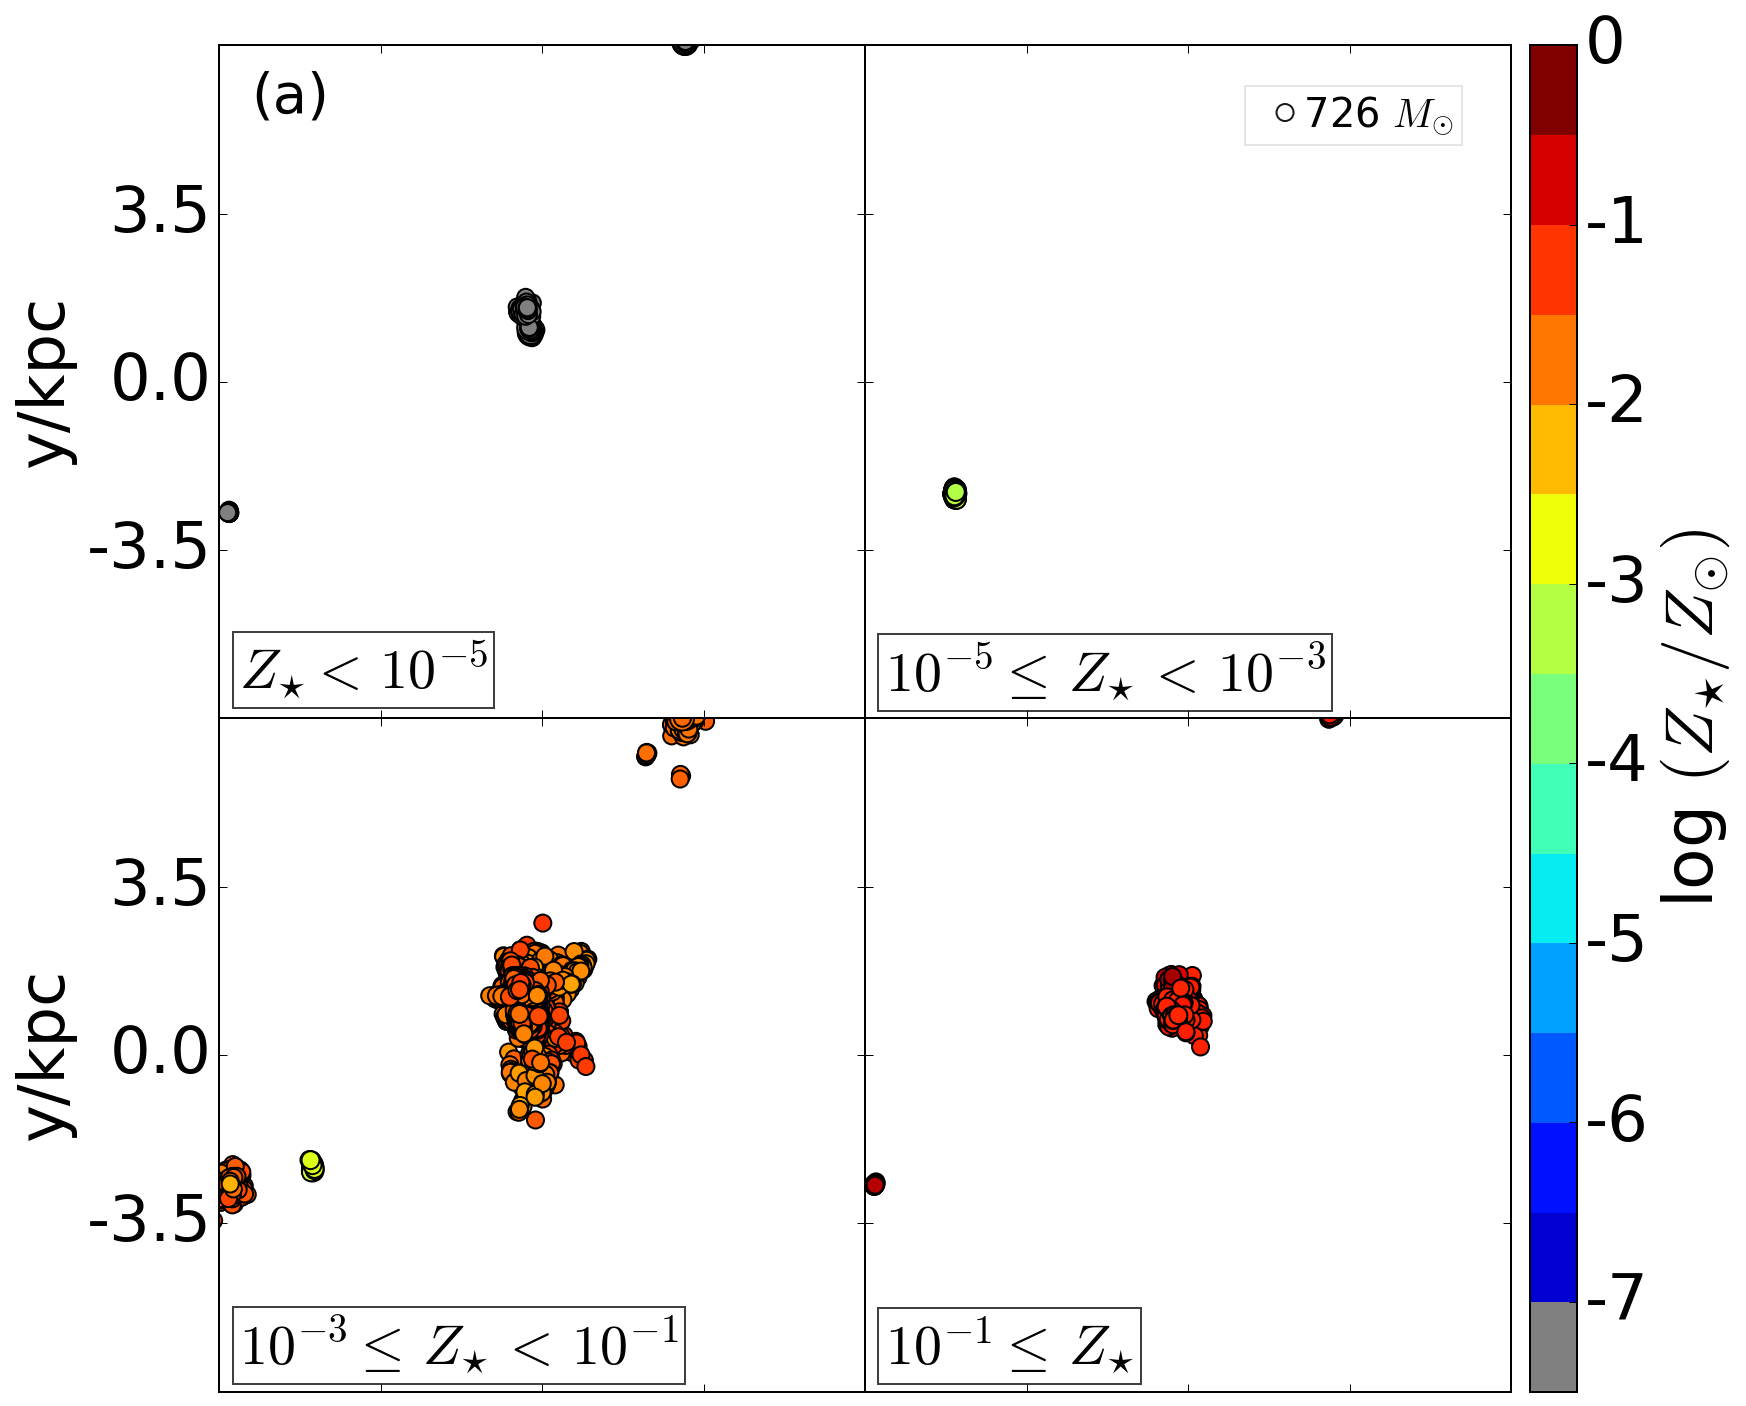

In [43]:
###
### Plot metallicity in 4 subplots
###
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in [ax1,ax2]], visible=False)
plt.setp([a.get_yticklabels() for a in [ax2,ax4]], visible=False)
plt.setp([a.set_xlim([-sbox/2.0,sbox/2.0]) for a in [ax1,ax2,ax3,ax4]])
plt.setp([a.set_ylim([-sbox/2.0,sbox/2.0]) for a in [ax2,ax4,ax3,ax4]])

xcoord = haloStars[:,0]; ycoord = haloStars[:,1]
ax1.scatter(xcoord[rngf1], ycoord[rngf1], s=halomass[rngf1]/dotNorm, c=zf1, cmap=cmap,vmin=-7.5, vmax=0)
ax2.scatter(xcoord[rngf2], ycoord[rngf2], s=halomass[rngf2]/dotNorm, c=zf2, cmap=cmap,vmin=-7.5, vmax=0)
ax3.scatter(xcoord[rngf3], ycoord[rngf3], s=halomass[rngf3]/dotNorm, c=zf3, cmap=cmap,vmin=-7.5, vmax=0)
ax4.scatter(xcoord[rngf4], ycoord[rngf4], s=halomass[rngf4]/dotNorm, c=zf4, cmap=cmap,vmin=-7.5, vmax=0)
# create a second axes for the colorbar
ax5 = fig.add_axes([0.85, 0.1, 0.025, 0.85])
cb = mpl.colorbar.ColorbarBase(ax5, cmap=cmap, norm=norm, spacing='proportional',
                                ticks=ticks, boundaries=bounds, format='%1i')

## fig.suptitle('Star Particles z=%.1lf, %.1lf kpc comoving\nCenter: [%.2lf,%.2lf,%.2lf]'%
##              (z,comovbox,xo,yo,zo),size=24)

bbox = {'facecolor':'white', 'alpha':0.75, 'pad':3}
ax1.text(0.03,0.025,'$Z_{\star} <\, 10^{-5}$',bbox=bbox, fontsize=boxFontSize, 
         transform=ax1.transAxes, horizontalalignment='left', verticalalignment='bottom')
ax2.text(0.03,0.04,'$10^{-5} \leq\, Z_{\star}\, <\, 10^{-3}$',transform=ax2.transAxes,bbox=bbox,fontsize=boxFontSize)
ax3.text(0.03,0.04,'$10^{-3} \leq\, Z_{\star}\, <\, 10^{-1}$',transform=ax3.transAxes,bbox=bbox,fontsize=boxFontSize)
ax4.text(0.03,0.04,'$10^{-1} \leq\, Z_{\star}\,$',transform=ax4.transAxes,bbox=bbox,fontsize=boxFontSize)

ax1.text(0.05,0.9, '(a)', transform=ax1.transAxes, ha='left', fontsize=boxFontSize)
# ax2.text(xpos,ypos,'(b)',fontsize=boxFontSize)
# ax3.text(xpos,ypos,'(c)',fontsize=boxFontSize)
# ax4.text(xpos,ypos,'(d)',fontsize=boxFontSize)

startx, endx = ax1.get_xlim(); dx = (endx-startx) * 0.1
starty, endy = ax1.get_ylim(); dy = (endy-starty) * 0.1
print(startx,endx)
print(startx-endx)
print(sbox)

tics = [-sbox/4.0,0,sbox/4.0]
formatter = FormatStrFormatter(fmt)
ax1.yaxis.set_ticks(tics); ax1.yaxis.set_major_formatter(formatter)
ax3.yaxis.set_ticks(tics); ax3.yaxis.set_major_formatter(formatter)
ax3.xaxis.set_ticks(tics); ax3.xaxis.set_major_formatter(nullfmt)
ax4.xaxis.set_ticks(tics); ax4.xaxis.set_major_formatter(nullfmt)
ax3.xaxis.set_ticks(tics); ax3.xaxis.set_major_formatter(nullfmt)
ax4.xaxis.set_ticks(tics); ax4.xaxis.set_major_formatter(nullfmt)

#ax3.set_xlabel('x kpc')
#ax4.set_xlabel('x kpc')
ax1.set_ylabel('y/kpc')
ax3.set_ylabel('y/kpc')

xpos = ax2.get_xlim()[1] - 0.15 * ax1.get_xlim()[1]
ypos = ax2.get_ylim()[1] - 0.25 * ax1.get_ylim()[1]
size = min(mass)
legStr = '    {:.0f}'.format(size)
legStr = legStr + " $M_{\odot}$"
bbox = {'facecolor':'white', 'alpha':0.1, 'pad':4}
ax2.text(.6,.88, legStr, transform=ax2.transAxes,
             ha='left', bbox=bbox, size=20)
ax2.scatter([0.65],[0.9],transform=ax2.transAxes, s=np.array([min(mass)])/dotNorm,facecolors='none')


# Control number of ticks
#ax3.locator_params(nbins=3)
#ax4.locator_params(nbins=3)
#ax1.locator_params(nbins=3)

ax5.set_ylabel('log $(Z_{\star}/Z_{\odot})$', size=labelSize)
plt.subplots_adjust(left=0.15, bottom=0.1, right=0.84, top=.95, wspace=.0, hspace=.0)
#plt.savefig("SP_Z_locs_Zcut_z=%04.1lf-%d.pdf"%(z,haloNum), dpi=fig.dpi,bbox_inches='tight')
plt.show()




(-2.1846153846153848, 2.1846153846153848)
-4.36923076923
4.36923076923


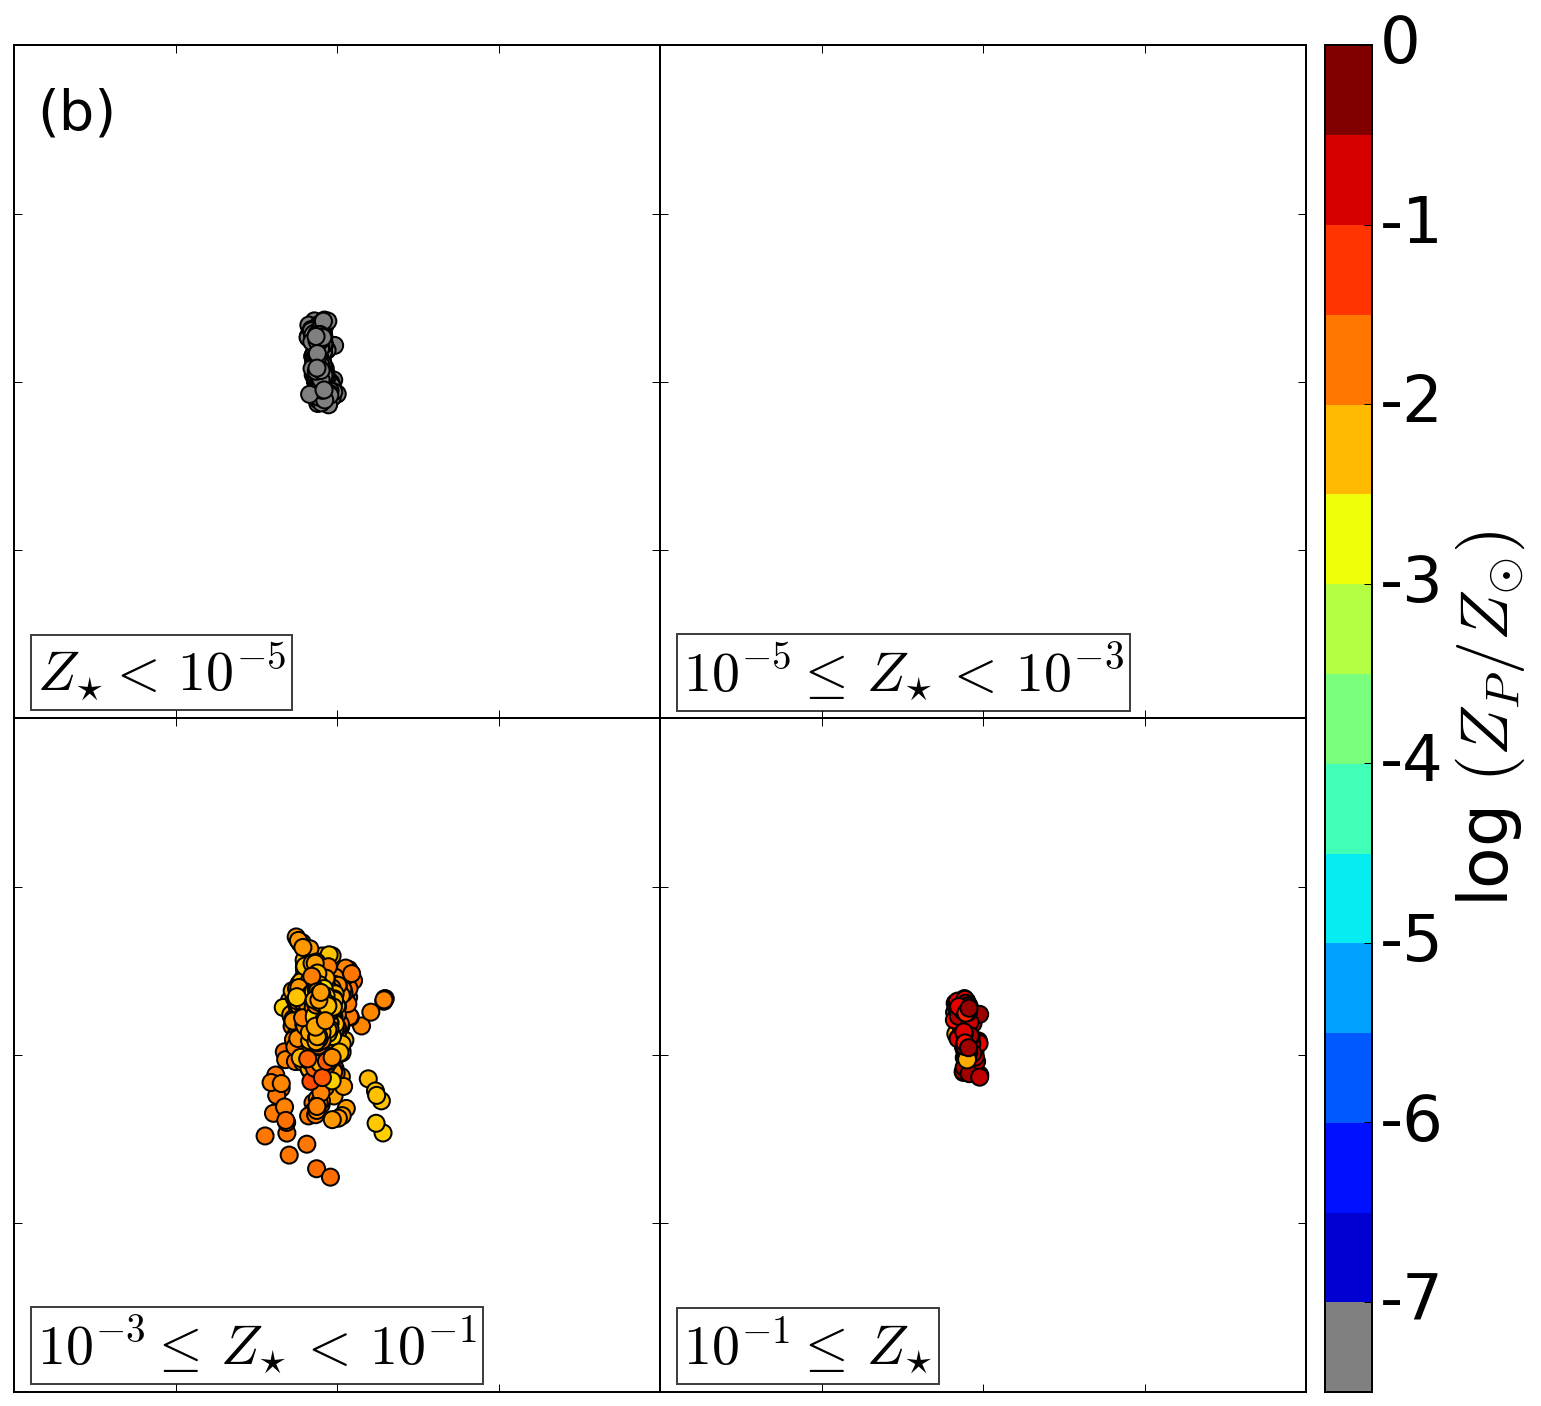

In [256]:
# Color according to Z_P ... but cut on Z/Z_fpol
# Use Z cuts for PPF data... 
z1=np.log10(haloPZf[rngf1])
z2=np.log10(haloPZf[rngf2])
z3=np.log10(haloPZf[rngf3])
z4=np.log10(haloPZf[rngf4])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in [ax1,ax2]], visible=False)
plt.setp([a.get_yticklabels() for a in [ax2,ax4]], visible=False)
plt.setp([a.set_xlim([-sbox/2.0,sbox/2.0]) for a in [ax1,ax2,ax3,ax4]])
plt.setp([a.set_ylim([-sbox/2.0,sbox/2.0]) for a in [ax2,ax4,ax3,ax4]])

xcoord = haloStars[:,0]; ycoord = haloStars[:,1]
ax1.scatter(xcoord[rngf1], ycoord[rngf1], s=halomass[rngf1]/dotNorm, c=z1, cmap=cmap,vmin=-7.5, vmax=0)
ax2.scatter(xcoord[rngf2], ycoord[rngf2], s=halomass[rngf2]/dotNorm, c=z2, cmap=cmap,vmin=-7.5, vmax=0)
ax3.scatter(xcoord[rngf3], ycoord[rngf3], s=halomass[rngf3]/dotNorm, c=z3, cmap=cmap,vmin=-7.5, vmax=0)
ax4.scatter(xcoord[rngf4], ycoord[rngf4], s=halomass[rngf4]/dotNorm, c=z4, cmap=cmap,vmin=-7.5, vmax=0)
# create a second axes for the colorbar
ax5 = fig.add_axes([0.85, 0.1, 0.025, 0.85])
cb = mpl.colorbar.ColorbarBase(ax5, cmap=cmap, norm=norm, spacing='proportional',
                                ticks=ticks, boundaries=bounds, format='%1i')
## fig.suptitle('Star Particles z=%.1lf, %.1lf kpc comoving\nCenter: [%.2lf,%.2lf,%.2lf]'%
##              (z,comovbox,xo,yo,zo),size=24)
xpos = ax1.get_xlim()[0] - 0.07 * ax1.get_xlim()[0]
ypos = ax1.get_ylim()[0] - 0.08 * ax1.get_ylim()[0]
bbox = {'facecolor':'white', 'alpha':0.75, 'pad':3}
ax1.text(xpos,ypos,'$Z_{\star} <\, 10^{-5}$',bbox=bbox, fontsize=boxFontSize)
ax2.text(xpos,ypos,'$10^{-5} \leq\, Z_{\star}\, <\, 10^{-3}$',bbox=bbox,fontsize=boxFontSize)
ax3.text(xpos,ypos,'$10^{-3} \leq\, Z_{\star}\, <\, 10^{-1}$',bbox=bbox,fontsize=boxFontSize)
ax4.text(xpos,ypos,'$10^{-1} \leq\, Z_{\star}\,$',bbox=bbox,fontsize=boxFontSize)

xpos = ax1.get_xlim()[0] - 0.07 * ax1.get_xlim()[0]
ypos = ax2.get_ylim()[1] - 0.25 * ax1.get_ylim()[1]
ax1.text(xpos,ypos,'(b)', fontsize=boxFontSize)
# ax2.text(xpos,ypos,'(b)',fontsize=boxFontSize)
# ax3.text(xpos,ypos,'(c)',fontsize=boxFontSize)
# ax4.text(xpos,ypos,'(d)',fontsize=boxFontSize)

startx, endx = ax1.get_xlim(); dx = (endx-startx) * 0.1
starty, endy = ax1.get_ylim(); dy = (endy-starty) * 0.1

tics = [-sbox/4.0,0,sbox/4.0]
formatter = FormatStrFormatter(fmt)
ax1.yaxis.set_ticks(tics); ax1.yaxis.set_major_formatter(formatter)
ax3.yaxis.set_ticks(tics); ax3.yaxis.set_major_formatter(formatter)
ax3.xaxis.set_ticks(tics); ax3.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_ticks(tics); ax4.xaxis.set_major_formatter(formatter)
ax1.yaxis.set_ticks(tics); ax1.yaxis.set_major_formatter(nullfmt)
ax3.yaxis.set_ticks(tics); ax3.yaxis.set_major_formatter(nullfmt)
ax3.xaxis.set_ticks(tics); ax3.xaxis.set_major_formatter(nullfmt)
ax4.xaxis.set_ticks(tics); ax4.xaxis.set_major_formatter(nullfmt)
print(startx,endx)
print(startx-endx)
print(sbox)

#ax3.set_xlabel('x kpc')
#ax4.set_xlabel('x kpc')
#ax1.set_ylabel('y kpc')
#ax3.set_ylabel('y kpc')

# Control number of ticks
#ax3.locator_params(nbins=3)
#ax4.locator_params(nbins=3)
#ax1.locator_params(nbins=3)

ax5.set_ylabel(r'log $(Z_{P}/Z_{\odot})$', size=labelSize)
plt.subplots_adjust(left=0.15, bottom=0.1, right=0.84, top=.95, wspace=.0, hspace=.0)
#plt.savefig("SP_PZ_locs_Zcut_z=%04.1lf-%d.pdf"%(z,i), dpi=fig.dpi,bbox_inches='tight')
plt.show()



(-2.1846153846153848, 2.1846153846153848)
-4.36923076923
4.36923076923


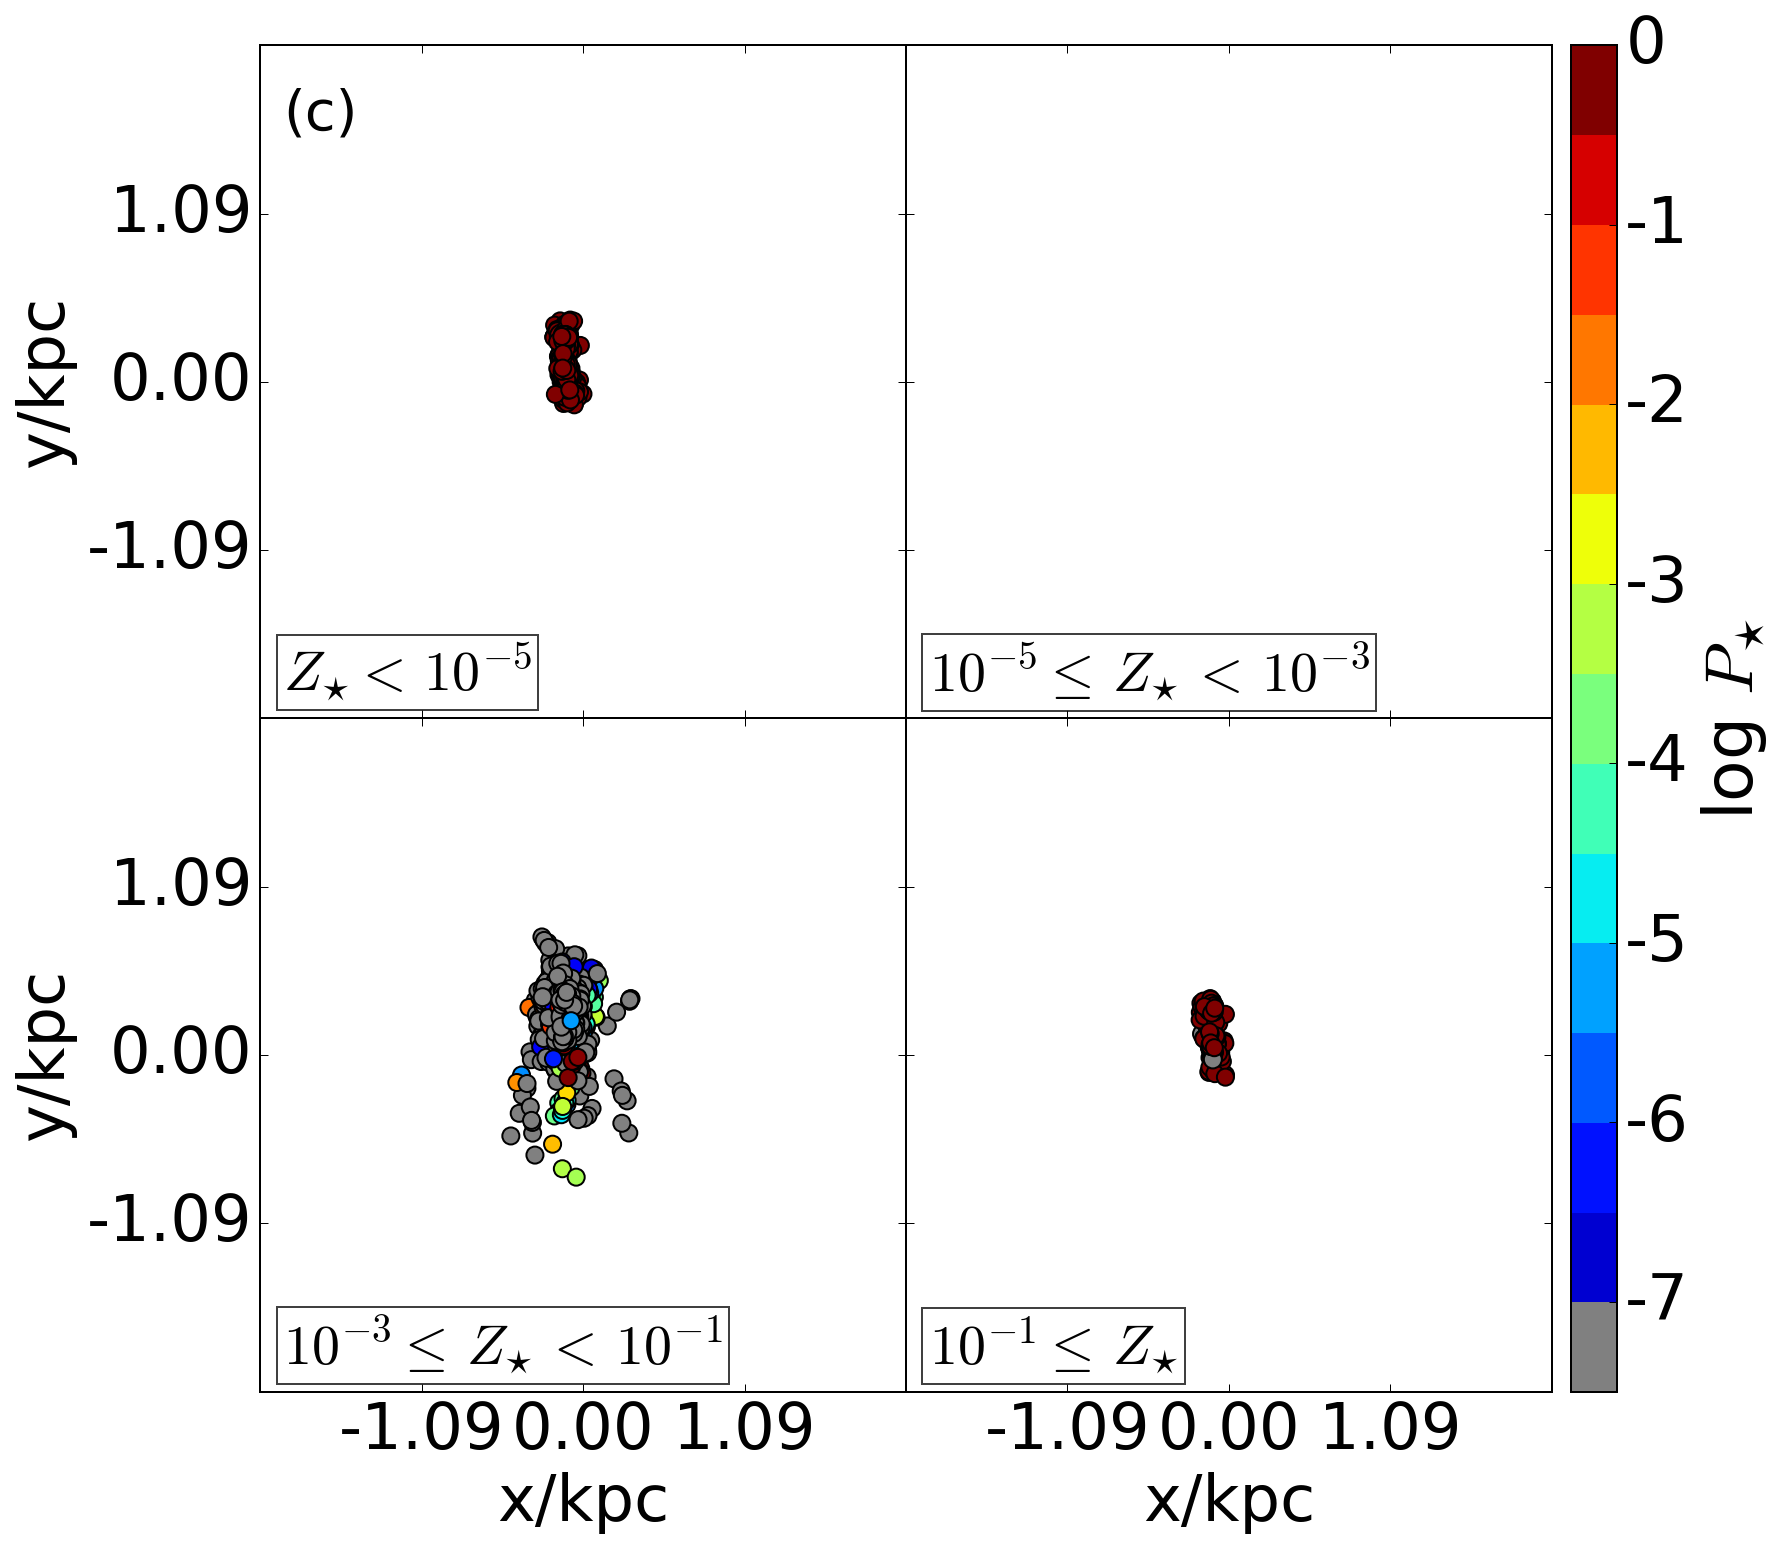

In [257]:
#rng1 = (PPF < 1.e-5)
#rng2 = ((PPF >= 1.e-5) & (PPF < 1.e-3))
#rng3 = ((PPF >= 1.e-3) & (PPF < 1.e-1))
#rng4 = (PPF >= 1.e-1)
# Use Z cuts for PPF data... 
z1=np.log10(haloPPF[rngf1])
z2=np.log10(haloPPF[rngf2])
z3=np.log10(haloPPF[rngf3])
z4=np.log10(haloPPF[rngf4])
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in [ax1,ax2]], visible=False)
plt.setp([a.get_yticklabels() for a in [ax2,ax4]], visible=False)
plt.setp([a.set_xlim([-sbox/2.0,sbox/2.0]) for a in [ax1,ax2,ax3,ax4]])
plt.setp([a.set_ylim([-sbox/2.0,sbox/2.0]) for a in [ax2,ax4,ax3,ax4]])

xcoord = haloStars[:,0]; ycoord = haloStars[:,1]
ax1.scatter(xcoord[rngf1], ycoord[rngf1], s=halomass[rngf1]/dotNorm, c=z1, cmap=cmap,vmin=-7.5, vmax=0)
ax2.scatter(xcoord[rngf2], ycoord[rngf2], s=halomass[rngf2]/dotNorm, c=z2, cmap=cmap,vmin=-7.5, vmax=0)
ax3.scatter(xcoord[rngf3], ycoord[rngf3], s=halomass[rngf3]/dotNorm, c=z3, cmap=cmap,vmin=-7.5, vmax=0)
ax4.scatter(xcoord[rngf4], ycoord[rngf4], s=halomass[rngf4]/dotNorm, c=z4, cmap=cmap,vmin=-7.5, vmax=0)
# create a second axes for the colorbar
ax5 = fig.add_axes([0.85, 0.1, 0.025, 0.85])
cb = mpl.colorbar.ColorbarBase(ax5, cmap=cmap, norm=norm, spacing='proportional',
                                ticks=ticks, boundaries=bounds, format='%1i')
## fig.suptitle('Star Particles z=%.1lf, %.1lf kpc comoving\nCenter: [%.2lf,%.2lf,%.2lf]'%
##              (z,comovbox,xo,yo,zo),size=24)
xpos = ax1.get_xlim()[0] - 0.07 * ax1.get_xlim()[0]
ypos = ax1.get_ylim()[0] - 0.08 * ax1.get_ylim()[0]
bbox = {'facecolor':'white', 'alpha':0.75, 'pad':3}
ax1.text(xpos,ypos,'$Z_{\star} <\, 10^{-5}$',bbox=bbox, fontsize=boxFontSize)
ax2.text(xpos,ypos,'$10^{-5} \leq\, Z_{\star}\, <\, 10^{-3}$',bbox=bbox,fontsize=boxFontSize)
ax3.text(xpos,ypos,'$10^{-3} \leq\, Z_{\star}\, <\, 10^{-1}$',bbox=bbox,fontsize=boxFontSize)
ax4.text(xpos,ypos,'$10^{-1} \leq\, Z_{\star}\,$',bbox=bbox,fontsize=boxFontSize)

xpos = ax1.get_xlim()[0] - 0.07 * ax1.get_xlim()[0]
ypos = ax2.get_ylim()[1] - 0.25 * ax1.get_ylim()[1]
ax1.text(xpos,ypos,'(c)', fontsize=boxFontSize)
# ax2.text(xpos,ypos,'(b)',fontsize=boxFontSize)
# ax3.text(xpos,ypos,'(c)',fontsize=boxFontSize)
# ax4.text(xpos,ypos,'(d)',fontsize=boxFontSize)

startx, endx = ax1.get_xlim(); dx = (endx-startx) * 0.1
starty, endy = ax1.get_ylim(); dy = (endy-starty) * 0.1
formatter = FormatStrFormatter(fmt)
ax1.yaxis.set_ticks(tics); ax1.yaxis.set_major_formatter(formatter)
ax3.yaxis.set_ticks(tics); ax3.yaxis.set_major_formatter(formatter)
ax3.xaxis.set_ticks(tics); ax3.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_ticks(tics); ax4.xaxis.set_major_formatter(formatter)

ax3.set_xlabel('x/kpc')
ax4.set_xlabel('x/kpc')
ax1.set_ylabel('y/kpc')
ax3.set_ylabel('y/kpc')
print(startx,endx)
print(startx-endx)
print(sbox)


# Control number of ticks
#ax3.locator_params(nbins=3)
#ax4.locator_params(nbins=3)
#ax1.locator_params(nbins=3)

ax5.set_ylabel('log $P_{\star}$', size=labelSize)
plt.subplots_adjust(left=0.15, bottom=0.1, right=0.84, top=.95, wspace=.0, hspace=.0)
#plt.savefig("SP_PF_locs_Zcut_z=%04.1lf-%d.pdf"%(z,i), dpi=fig.dpi,bbox_inches='tight')
plt.show()



(-2.1846153846153848, 2.1846153846153848)
-4.36923076923
4.36923076923


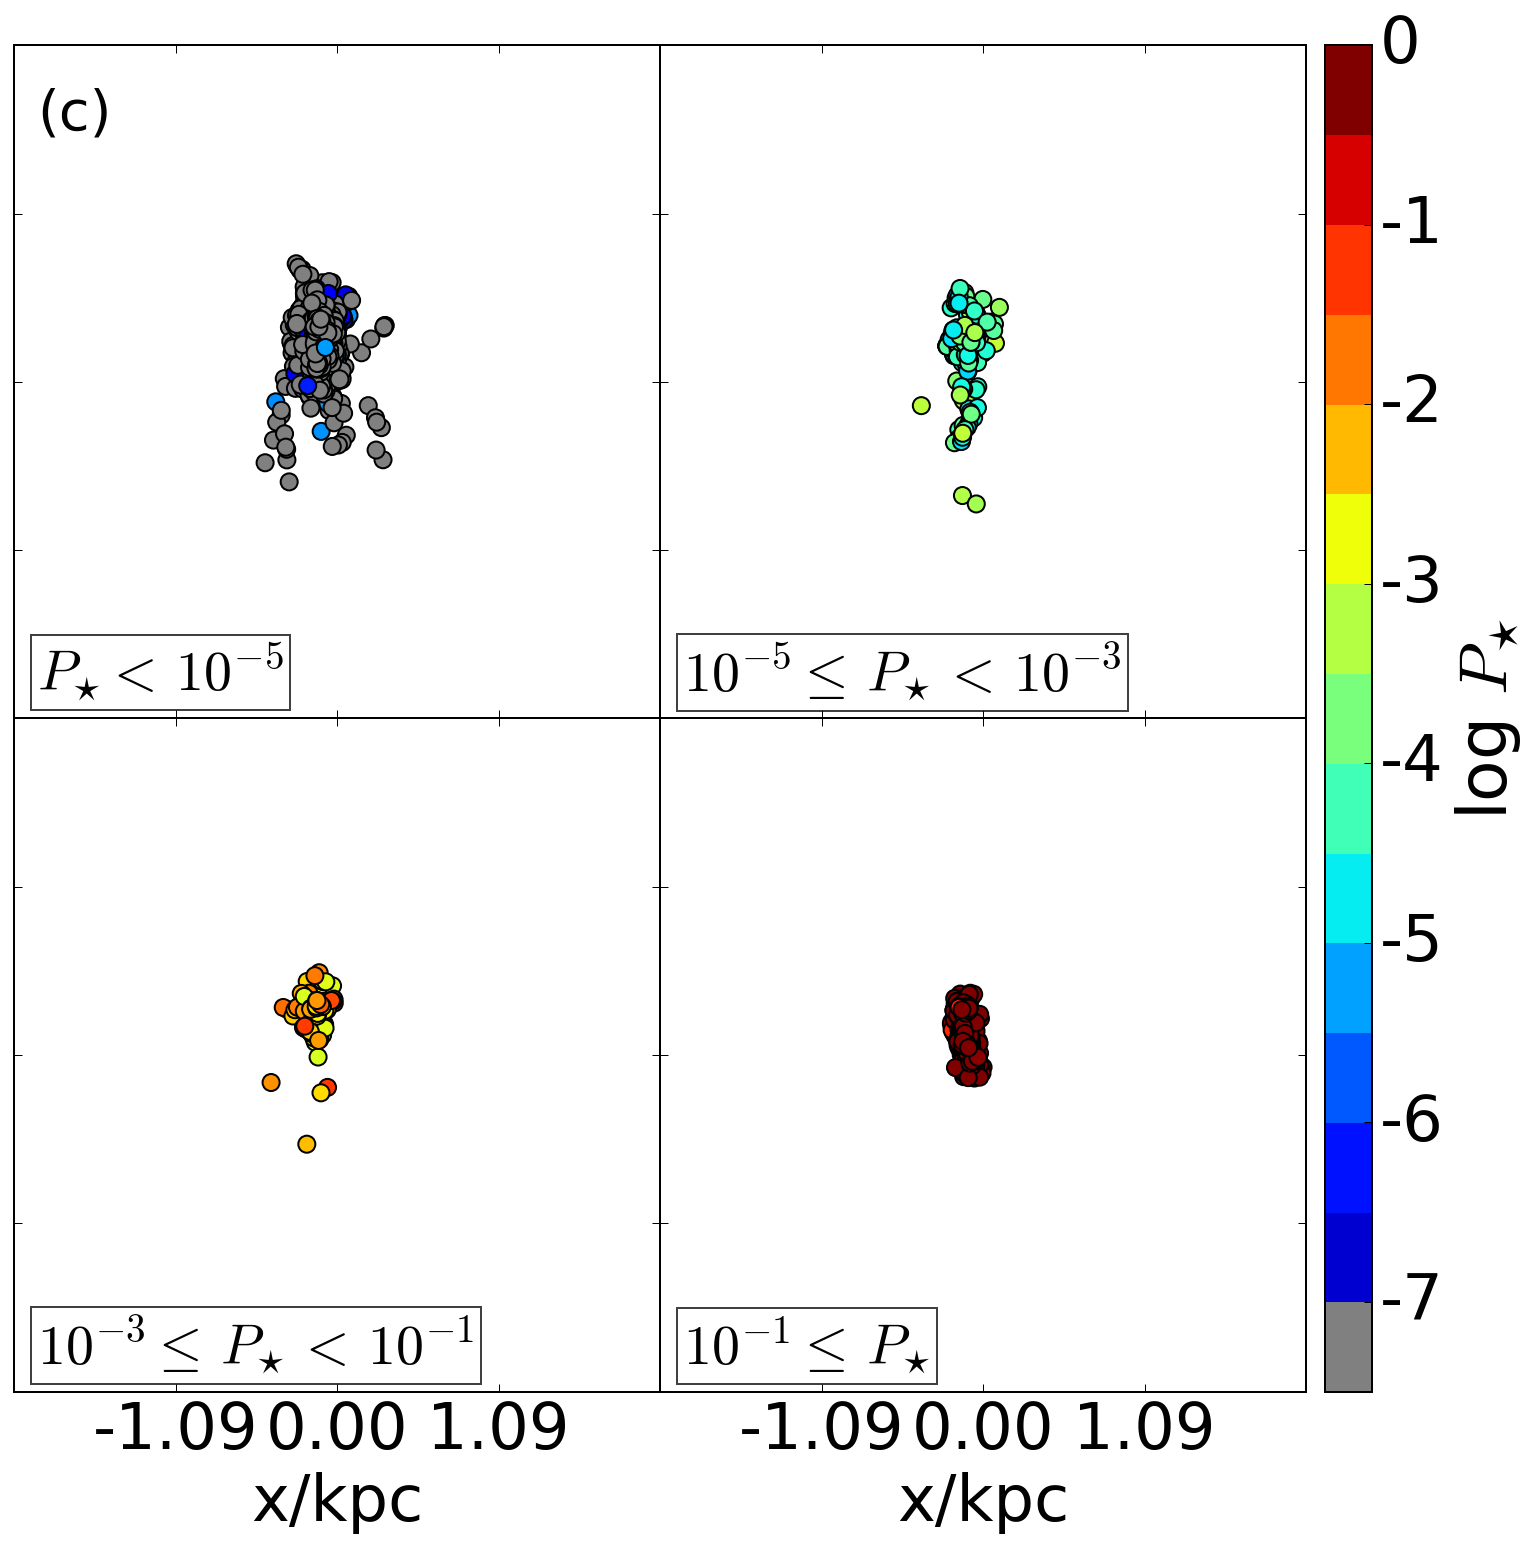

In [259]:
rng1 = (haloPPF <= 1.e-5)
rng2 = ((haloPPF > 1.e-5) & (haloPPF <= 1.e-3))
rng3 = ((haloPPF > 1.e-3) & (haloPPF <= 1.e-1))
rng4 = (haloPPF > 1.e-1)
# Use PF cuts for PPF data... 
z1=np.log10(haloPPF[rng1])
z2=np.log10(haloPPF[rng2])
z3=np.log10(haloPPF[rng3])
z4=np.log10(haloPPF[rng4])
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in [ax1,ax2]], visible=False)
plt.setp([a.get_yticklabels() for a in [ax2,ax4]], visible=False)
plt.setp([a.set_xlim([-sbox/2.0,sbox/2.0]) for a in [ax1,ax2,ax3,ax4]])
plt.setp([a.set_ylim([-sbox/2.0,sbox/2.0]) for a in [ax2,ax4,ax3,ax4]])

xcoord = haloStars[:,0]; ycoord = haloStars[:,1]
ax1.scatter(xcoord[rng1], ycoord[rng1], s=halomass[rng1]/dotNorm, c=z1, cmap=cmap,vmin=-7.5, vmax=0)
ax2.scatter(xcoord[rng2], ycoord[rng2], s=halomass[rng2]/dotNorm, c=z2, cmap=cmap,vmin=-7.5, vmax=0)
ax3.scatter(xcoord[rng3], ycoord[rng3], s=halomass[rng3]/dotNorm, c=z3, cmap=cmap,vmin=-7.5, vmax=0)
ax4.scatter(xcoord[rng4], ycoord[rng4], s=halomass[rng4]/dotNorm, c=z4, cmap=cmap,vmin=-7.5, vmax=0)
# create a second axes for the colorbar
ax5 = fig.add_axes([0.85, 0.1, 0.025, 0.85])
cb = mpl.colorbar.ColorbarBase(ax5, cmap=cmap, norm=norm, spacing='proportional',
                                ticks=ticks, boundaries=bounds, format='%1i')
## fig.suptitle('Star Particles z=%.1lf, %.1lf kpc comoving\nCenter: [%.2lf,%.2lf,%.2lf]'%
##              (z,comovbox,xo,yo,zo),size=24)
xpos = ax1.get_xlim()[0] - 0.07 * ax1.get_xlim()[0]
ypos = ax1.get_ylim()[0] - 0.08 * ax1.get_ylim()[0]
bbox = {'facecolor':'white', 'alpha':0.75, 'pad':3}
ax1.text(xpos,ypos,'$P_{\star} <\, 10^{-5}$',bbox=bbox, fontsize=boxFontSize)
ax2.text(xpos,ypos,'$10^{-5} \leq\, P_{\star}\, <\, 10^{-3}$',bbox=bbox,fontsize=boxFontSize)
ax3.text(xpos,ypos,'$10^{-3} \leq\, P_{\star}\, <\, 10^{-1}$',bbox=bbox,fontsize=boxFontSize)
ax4.text(xpos,ypos,'$10^{-1} \leq\, P_{\star}$',bbox=bbox,fontsize=boxFontSize)

xpos = ax1.get_xlim()[0] - 0.07 * ax1.get_xlim()[0]
ypos = ax2.get_ylim()[1] - 0.25 * ax1.get_ylim()[1]
ax1.text(xpos,ypos,'(c)', fontsize=boxFontSize)
# ax2.text(xpos,ypos,'(b)',fontsize=boxFontSize)
# ax3.text(xpos,ypos,'(c)',fontsize=boxFontSize)
# ax4.text(xpos,ypos,'(d)',fontsize=boxFontSize)

startx, endx = ax1.get_xlim(); dx = (endx-startx) * 0.1
starty, endy = ax1.get_ylim(); dy = (endy-starty) * 0.1
formatter = FormatStrFormatter(fmt)
ax1.yaxis.set_ticks(tics); ax1.yaxis.set_major_formatter(nullfmt)
ax2.yaxis.set_ticks(tics); ax2.yaxis.set_major_formatter(nullfmt)
ax3.yaxis.set_ticks(tics); ax3.yaxis.set_major_formatter(nullfmt)
ax4.yaxis.set_ticks(tics); ax4.yaxis.set_major_formatter(nullfmt)
ax3.xaxis.set_ticks(tics); ax3.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_ticks(tics); ax4.xaxis.set_major_formatter(formatter)


ax3.set_xlabel('x/kpc')
ax4.set_xlabel('x/kpc')
#ax1.set_ylabel('y kpc')
#ax3.set_ylabel('y kpc')
print(startx,endx)
print(startx-endx)
print(sbox)

# Control number of ticks
#ax3.locator_params(nbins=3)
#ax4.locator_params(nbins=3)
#ax1.locator_params(nbins=3)

ax5.set_ylabel('log $P_{\star}$', size=34)
plt.subplots_adjust(left=0.15, bottom=0.1, right=0.84, top=.95, wspace=.0, hspace=.0)
#plt.savefig("SP_PF_locs_PFcut_z=%04.1lf-%d.pdf"%(z,i), dpi=fig.dpi,bbox_inches='tight')
plt.show()

In [ ]:
rng1 = (haloPPF <= 1.e-5)
rng2 = ((haloPPF > 1.e-5) & (haloPPF <= 1.e-3))
rng3 = ((haloPPF > 1.e-3) & (haloPPF <= 1.e-1))
rng4 = (haloPPF > 1.e-1)
# Use PF cuts for PPF data... 
z1=np.log10(haloPPF[rng1])
z2=np.log10(haloPPF[rng2])
z3=np.log10(haloPPF[rng3])
z4=np.log10(haloPPF[rng4])
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in [ax1,ax2]], visible=False)
plt.setp([a.get_yticklabels() for a in [ax2,ax4]], visible=False)
plt.setp([a.set_xlim([-sbox/2.0,sbox/2.0]) for a in [ax1,ax2,ax3,ax4]])
plt.setp([a.set_ylim([-sbox/2.0,sbox/2.0]) for a in [ax2,ax4,ax3,ax4]])

xcoord = haloStars[:,0]; ycoord = haloStars[:,1]
ax4.scatter(xcoord[rng1], ycoord[rng1], s=halomass[rng1]/dotNorm, c=z1, cmap=cmap,vmin=-7.5, vmax=0)
ax3.scatter(xcoord[rng2], ycoord[rng2], s=halomass[rng2]/dotNorm, c=z2, cmap=cmap,vmin=-7.5, vmax=0)
ax2.scatter(xcoord[rng3], ycoord[rng3], s=halomass[rng3]/dotNorm, c=z3, cmap=cmap,vmin=-7.5, vmax=0)
ax1.scatter(xcoord[rng4], ycoord[rng4], s=halomass[rng4]/dotNorm, c=z4, cmap=cmap,vmin=-7.5, vmax=0)
# create a second axes for the colorbar
ax5 = fig.add_axes([0.85, 0.1, 0.025, 0.85])
cb = mpl.colorbar.ColorbarBase(ax5, cmap=cmap, norm=norm, spacing='proportional',
                                ticks=ticks, boundaries=bounds, format='%1i')
## fig.suptitle('Star Particles z=%.1lf, %.1lf kpc comoving\nCenter: [%.2lf,%.2lf,%.2lf]'%
##              (z,comovbox,xo,yo,zo),size=24)
xpos = ax1.get_xlim()[0] - 0.07 * ax1.get_xlim()[0]
ypos = ax1.get_ylim()[0] - 0.08 * ax1.get_ylim()[0]
bbox = {'facecolor':'white', 'alpha':0.75, 'pad':3}
ax4.text(xpos,ypos,'$P_{\star} <\, 10^{-5}$',bbox=bbox, fontsize=boxFontSize)
ax3.text(xpos,ypos,'$10^{-5} \leq\, P_{\star}\, <\, 10^{-3}$',bbox=bbox,fontsize=boxFontSize)
ax2.text(xpos,ypos,'$10^{-3} \leq\, P_{\star}\, <\, 10^{-1}$',bbox=bbox,fontsize=boxFontSize)
ax1.text(xpos,ypos,'$10^{-1} \leq\, P_{\star}$',bbox=bbox,fontsize=boxFontSize)

xpos = ax1.get_xlim()[0] - 0.07 * ax1.get_xlim()[0]
ypos = ax2.get_ylim()[1] - 0.25 * ax1.get_ylim()[1]
ax1.text(xpos,ypos,'(c)', fontsize=boxFontSize)
# ax2.text(xpos,ypos,'(b)',fontsize=boxFontSize)
# ax3.text(xpos,ypos,'(c)',fontsize=boxFontSize)
# ax4.text(xpos,ypos,'(d)',fontsize=boxFontSize)

startx, endx = ax1.get_xlim(); dx = (endx-startx) * 0.1
starty, endy = ax1.get_ylim(); dy = (endy-starty) * 0.1
formatter = FormatStrFormatter(fmt)
ax1.yaxis.set_ticks(tics); ax1.yaxis.set_major_formatter(formatter)
ax3.yaxis.set_ticks(tics); ax3.yaxis.set_major_formatter(formatter)
ax3.xaxis.set_ticks(tics); ax3.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_ticks(tics); ax4.xaxis.set_major_formatter(formatter)

#ax1.yaxis.set_ticks([]); ax1.yaxis.set_major_formatter(formatter)
#ax3.yaxis.set_ticks([]); ax3.yaxis.set_major_formatter(formatter)

ax3.set_xlabel('x/kpc')
ax4.set_xlabel('x/kpc')
ax1.set_ylabel('y/kpc')
ax3.set_ylabel('y/kpc')
print(startx,endx)
print(startx-endx)
print(sbox)

# Control number of ticks
#ax3.locator_params(nbins=3)
#ax4.locator_params(nbins=3)
#ax1.locator_params(nbins=3)

ax5.set_ylabel('log $P_{\star}$', size=34)
plt.subplots_adjust(left=0.15, bottom=0.1, right=0.84, top=.95, wspace=.0, hspace=.0)
#plt.savefig("SP_PF_locs_PFcut_z=%04.1lf-%d.pdf"%(z,i), dpi=fig.dpi,bbox_inches='tight')
plt.show()

In [ ]:
gc.collect()



(-2.1846153846153848, 2.1846153846153848)
-4.36923076923
4.36923076923


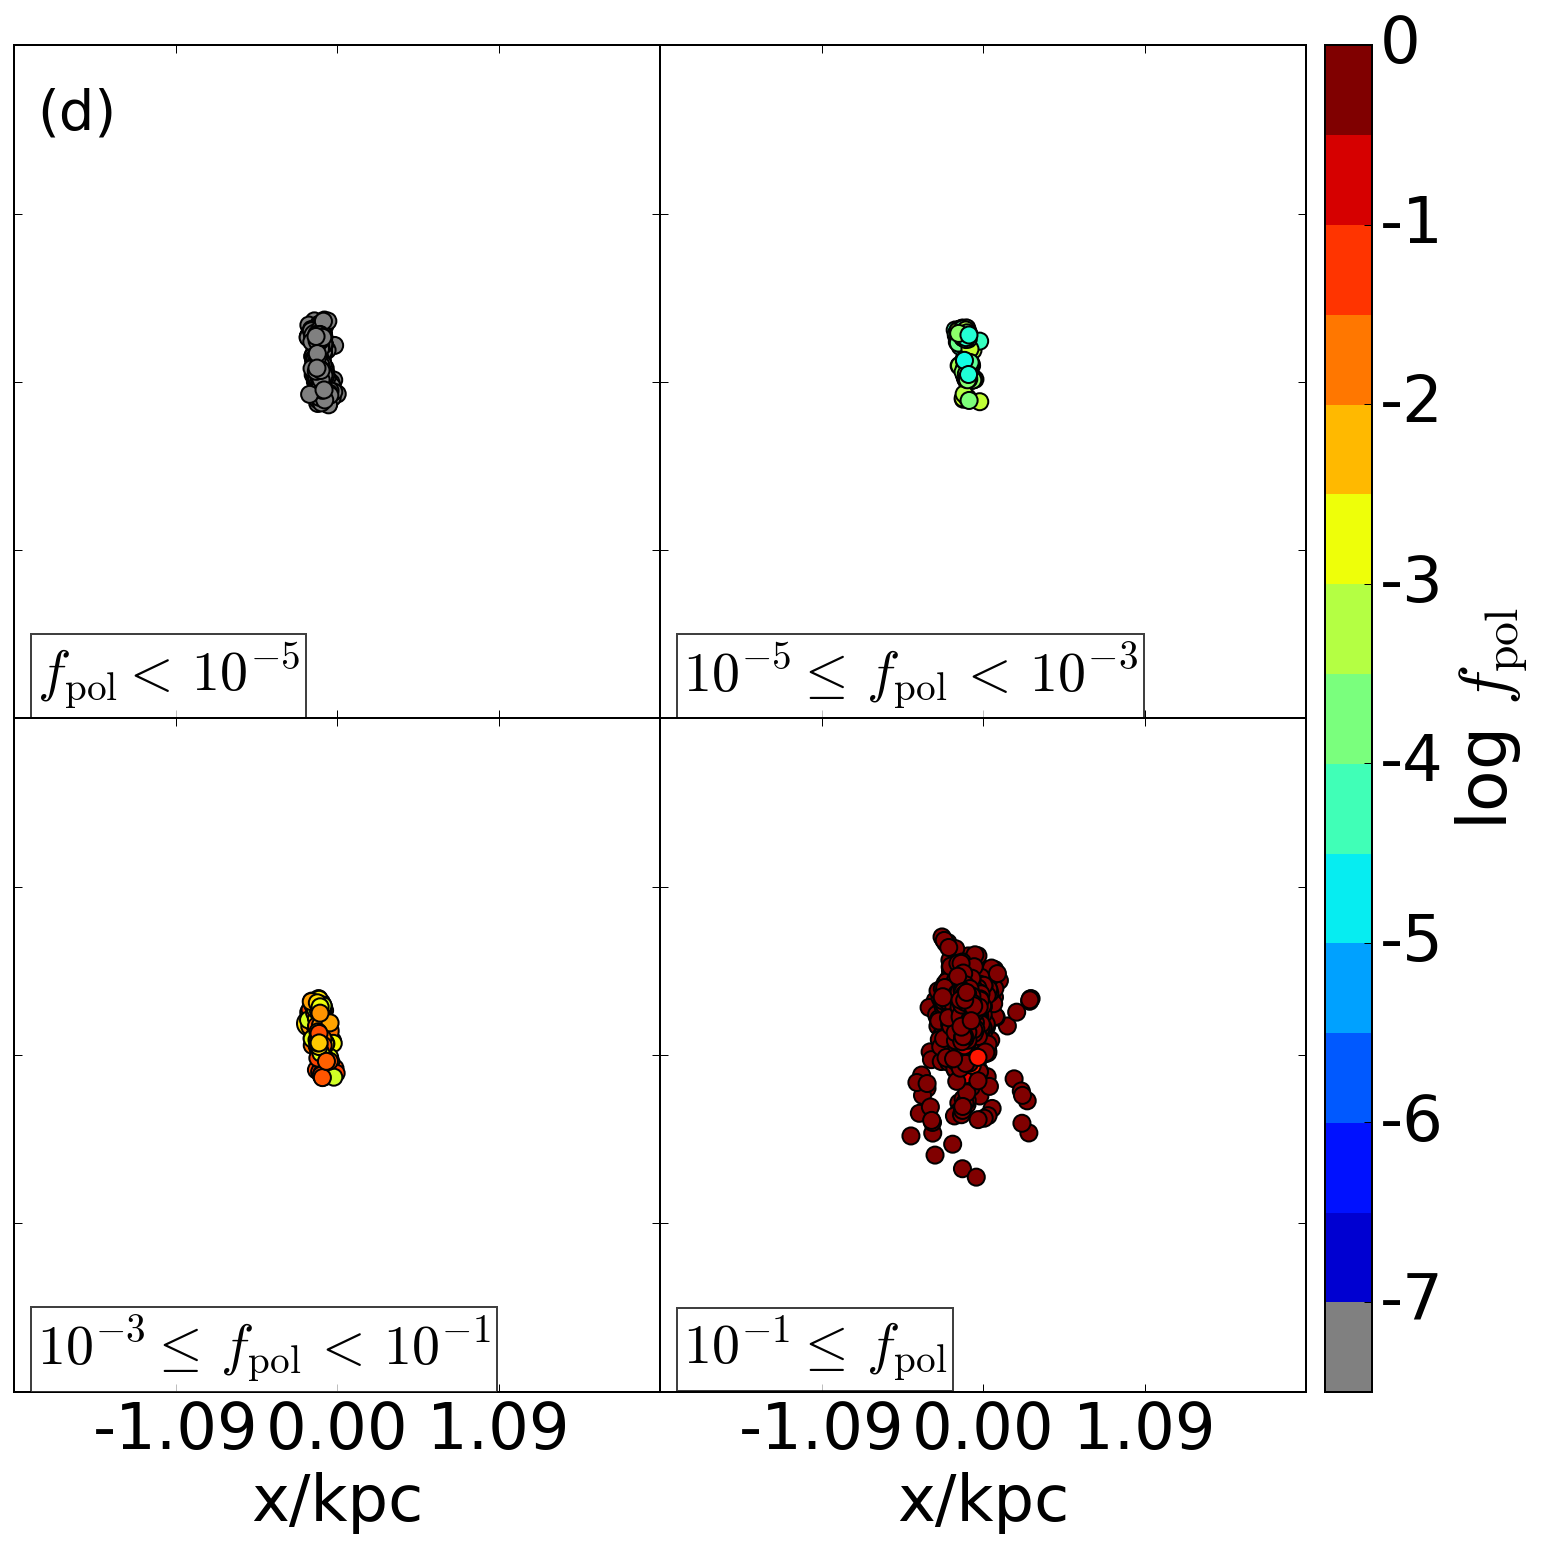

In [261]:
# Plotting fpol: a particle that is 99% pristine falls in P >= .1 ... 
# But that same particle is 1-.99 = 0.01 polluted ... and falls in 0.001 <= fpol < 0.1
halofpol[halofpol < 1e-7] = 10**-7.5
rng1 = (halofpol <= 1.e-5)
rng2 = ((halofpol > 1.e-5) & (halofpol <= 1.e-3))
rng3 = ((halofpol > 1.e-3) & (halofpol <= 1.e-1))
rng4 = (halofpol > 1.e-1)
# Use PF cuts for PPF data... 
z1=np.log10(halofpol[rng1])
z2=np.log10(halofpol[rng2])
z3=np.log10(halofpol[rng3])
z4=np.log10(halofpol[rng4])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in [ax1,ax2]], visible=False)
plt.setp([a.get_yticklabels() for a in [ax2,ax4]], visible=False)
plt.setp([a.set_xlim([-sbox/2.0,sbox/2.0]) for a in [ax1,ax2,ax3,ax4]])
plt.setp([a.set_ylim([-sbox/2.0,sbox/2.0]) for a in [ax2,ax4,ax3,ax4]])

xcoord = haloStars[:,0]; ycoord = haloStars[:,1]
ax1.scatter(xcoord[rng1], ycoord[rng1], s=halomass[rng1]/dotNorm, c=z1, cmap=cmap,vmin=-7.5, vmax=0)
ax2.scatter(xcoord[rng2], ycoord[rng2], s=halomass[rng2]/dotNorm, c=z2, cmap=cmap,vmin=-7.5, vmax=0)
ax3.scatter(xcoord[rng3], ycoord[rng3], s=halomass[rng3]/dotNorm, c=z3, cmap=cmap,vmin=-7.5, vmax=0)
ax4.scatter(xcoord[rng4], ycoord[rng4], s=halomass[rng4]/dotNorm, c=z4, cmap=cmap,vmin=-7.5, vmax=0)
# create a second axes for the colorbar
ax5 = fig.add_axes([0.85, 0.1, 0.025, 0.85])
cb = mpl.colorbar.ColorbarBase(ax5, cmap=cmap, norm=norm, spacing='proportional',
                                ticks=ticks, boundaries=bounds, format='%1i')
## fig.suptitle('Star Particles z=%.1lf, %.1lf kpc comoving\nCenter: [%.2lf,%.2lf,%.2lf]'%
##              (z,comovbox,xo,yo,zo),size=24)
xpos = ax1.get_xlim()[0] - 0.07 * ax1.get_xlim()[0]
ypos = ax1.get_ylim()[0] - 0.08 * ax1.get_ylim()[0]
bbox = {'facecolor':'white', 'alpha':0.75, 'pad':3}
ax1.text(xpos,ypos,r'$f_{\rm pol} <\, 10^{-5}$',bbox=bbox, fontsize=boxFontSize)
ax2.text(xpos,ypos,r'$10^{-5} \leq\, f_{\rm pol}\, <\, 10^{-3}$',bbox=bbox,fontsize=boxFontSize)
ax3.text(xpos,ypos,r'$10^{-3} \leq\, f_{\rm pol}\, <\, 10^{-1}$',bbox=bbox,fontsize=boxFontSize)
ax4.text(xpos,ypos,r'$10^{-1} \leq\, f_{\rm pol}$',bbox=bbox,fontsize=boxFontSize)

xpos = ax1.get_xlim()[0] - 0.07 * ax1.get_xlim()[0]
ypos = ax2.get_ylim()[1] - 0.25 * ax1.get_ylim()[1]
ax1.text(xpos,ypos,'(d)', fontsize=boxFontSize)
# ax2.text(xpos,ypos,'(b)',fontsize=boxFontSize)
# ax3.text(xpos,ypos,'(c)',fontsize=boxFontSize)
# ax4.text(xpos,ypos,'(d)',fontsize=boxFontSize)

startx, endx = ax1.get_xlim(); dx = (endx-startx) * 0.1
starty, endy = ax1.get_ylim(); dy = (endy-starty) * 0.1
formatter = FormatStrFormatter(fmt)
ax1.yaxis.set_ticks(tics); ax1.yaxis.set_major_formatter(formatter)
ax3.yaxis.set_ticks(tics); ax3.yaxis.set_major_formatter(formatter)
ax3.xaxis.set_ticks(tics); ax3.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_ticks(tics); ax4.xaxis.set_major_formatter(formatter)

ax1.yaxis.set_ticks(tics); ax1.yaxis.set_major_formatter(nullfmt)
ax3.yaxis.set_ticks(tics); ax3.yaxis.set_major_formatter(nullfmt)

ax3.set_xlabel('x/kpc')
ax4.set_xlabel('x/kpc')
#ax1.set_ylabel('y kpc')
#ax3.set_ylabel('y kpc')
print(startx,endx)
print(startx-endx)
print(sbox)

# Control number of ticks
#ax3.locator_params(nbins=3)
#ax4.locator_params(nbins=3)
#ax1.locator_params(nbins=3)

ax5.set_ylabel(r'log $f_{\rm pol}$', size=34)
plt.subplots_adjust(left=0.15, bottom=0.1, right=0.84, top=.95, wspace=.0, hspace=.0)
#plt.savefig("SP_fpol_locs_fpolcut_z=%04.1lf-%d.pdf"%(z,i), dpi=fig.dpi,bbox_inches='tight')
plt.show()